In [2]:
import pandas as pd
import numpy as np
from os import path
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

The first thing that we need to do is import the csv file that contains all of our cleaned data.

In [3]:
#Get the CSV file with all of our data
clean_data = pd.read_csv('data/cleaned/schwartau/schwartau.csv', encoding='UTF-8')

Next we are going to 'normalize' our timestamps. In order to do this, we are going to take its distance (1 step = 15 minute increment) from January 1st at time 00:00:00 in year 2017. This will give us an easier scale to base time off of.

In [4]:
#Alter timestamp data to reflect a circular distance from the beginning of the year
timestamps = np.array([x/clean_data.shape[0] for x in range(clean_data['timestamp'].shape[0])])

Here, we are going to create a numpy array to store our features in. Once our array is created, we are going to rotate the array by -90 degrees. This will result in rows with one entry from each column. Therefore, we are getting a list of features for every given timestamp. Then, we use Min Max Scalar to normalize our data between 0 and 1 without altering the distribution of the data.

In [25]:
#Create a numpy array to store our features in
X = np.array([
    clean_data['flow'].values,
    clean_data['temperature'].values,
    clean_data['arrivals'].values,
    clean_data['departures'].values,
    clean_data['weight'].values,
    clean_data['humidity'].values
])
#Rotate array so that each row is an entry of features from each attribute
X = np.rot90(X, k=-1)

#Normalize using Min Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Here, we will try to find an epsilon value for our DBSCAN model. Since this value represents the minimum distance needed for two points to be classifed in the same cluster, we figured that we could take a high percentile of the distances in order to only classify non-normal behavior in the data. This non-normal behavior is what we are interested, but this method also allows us to cluster healtyh behavior together as one big cluster.

In [29]:
#Let's try to find a good epsilon value
neighbors = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X)
distances = np.array([])
for x in X:
    distances = np.append(distances, [neighbors.kneighbors([x])[0][0][1]])
epsilon = np.percentile(distances, 99.975)
print(f'Try epsilon value {epsilon}')

Try epsilon value 0.07913454097563888


Now we build the model using the calculated epsilon and a min_sample size of 96. min_sample determines how many points must be clustered together to qualify as a cluster. We chose 96 since that would require a whole days worth of points needed to qualify as non-normal behavior. 

In [30]:
#Get model
model = DBSCAN(eps=epsilon, min_samples=96, n_jobs=None, metric='euclidean').fit(X)
#Get labels
labels = model.labels_
#Print number of clusters
clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'There are {clusters} cluster(s)')

There are 6 cluster(s)


Now, we graph each attribute by time.

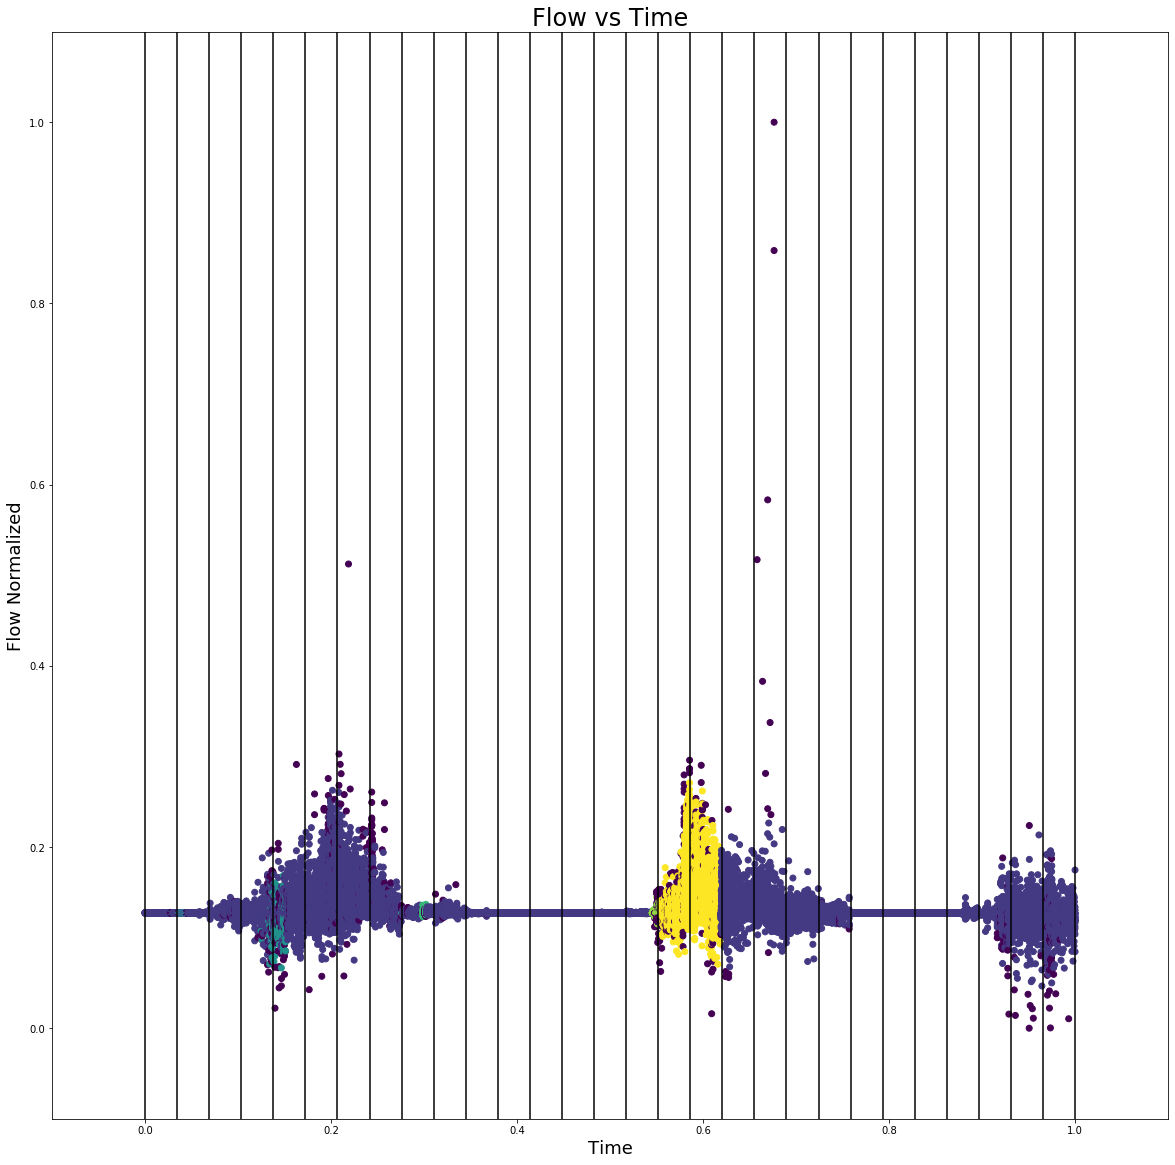

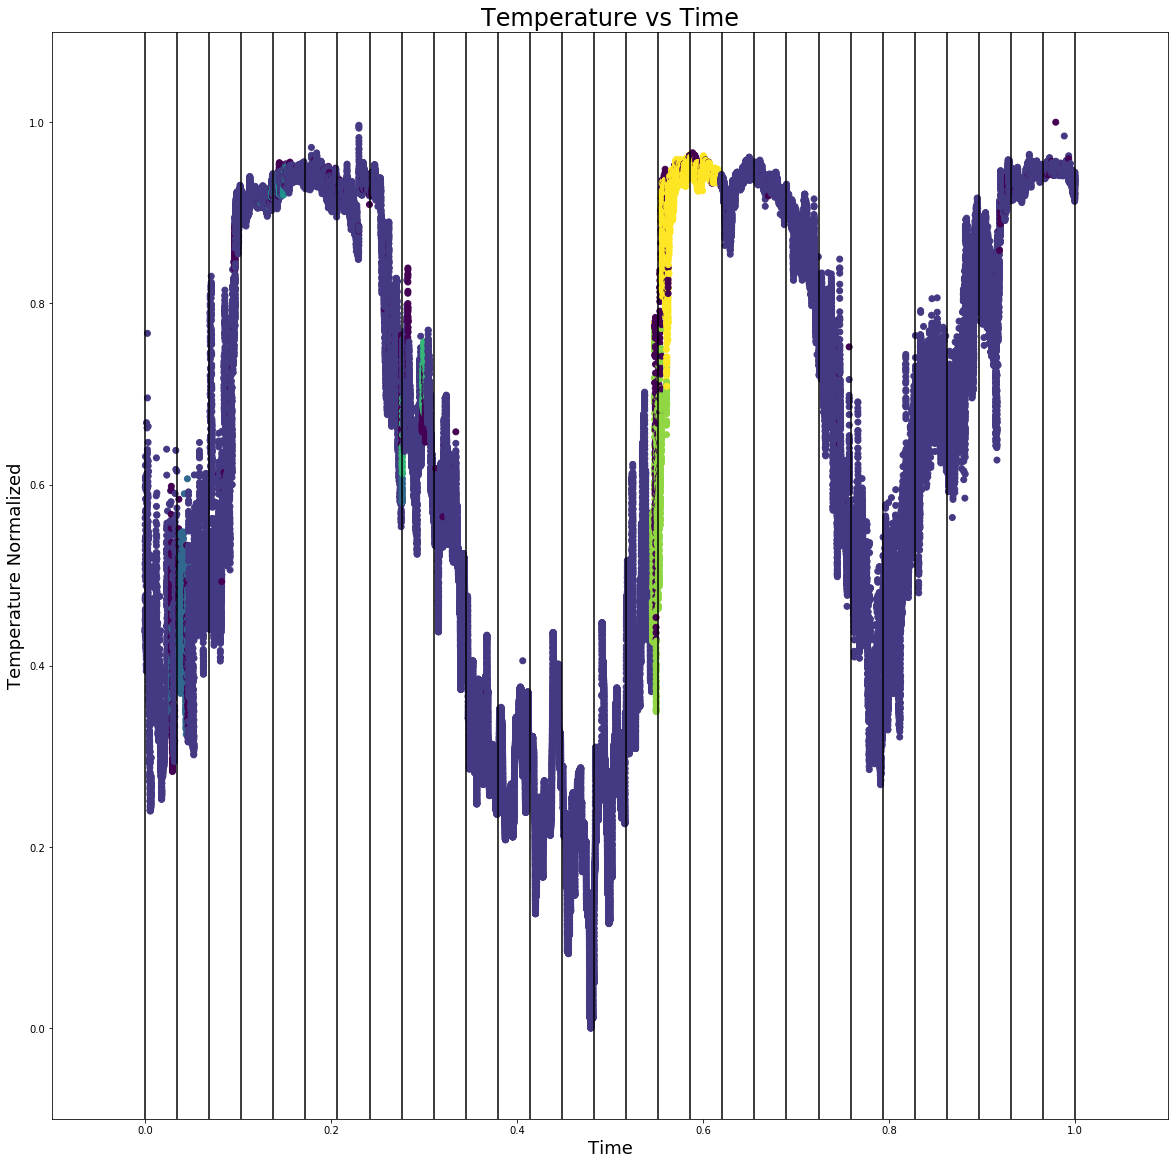

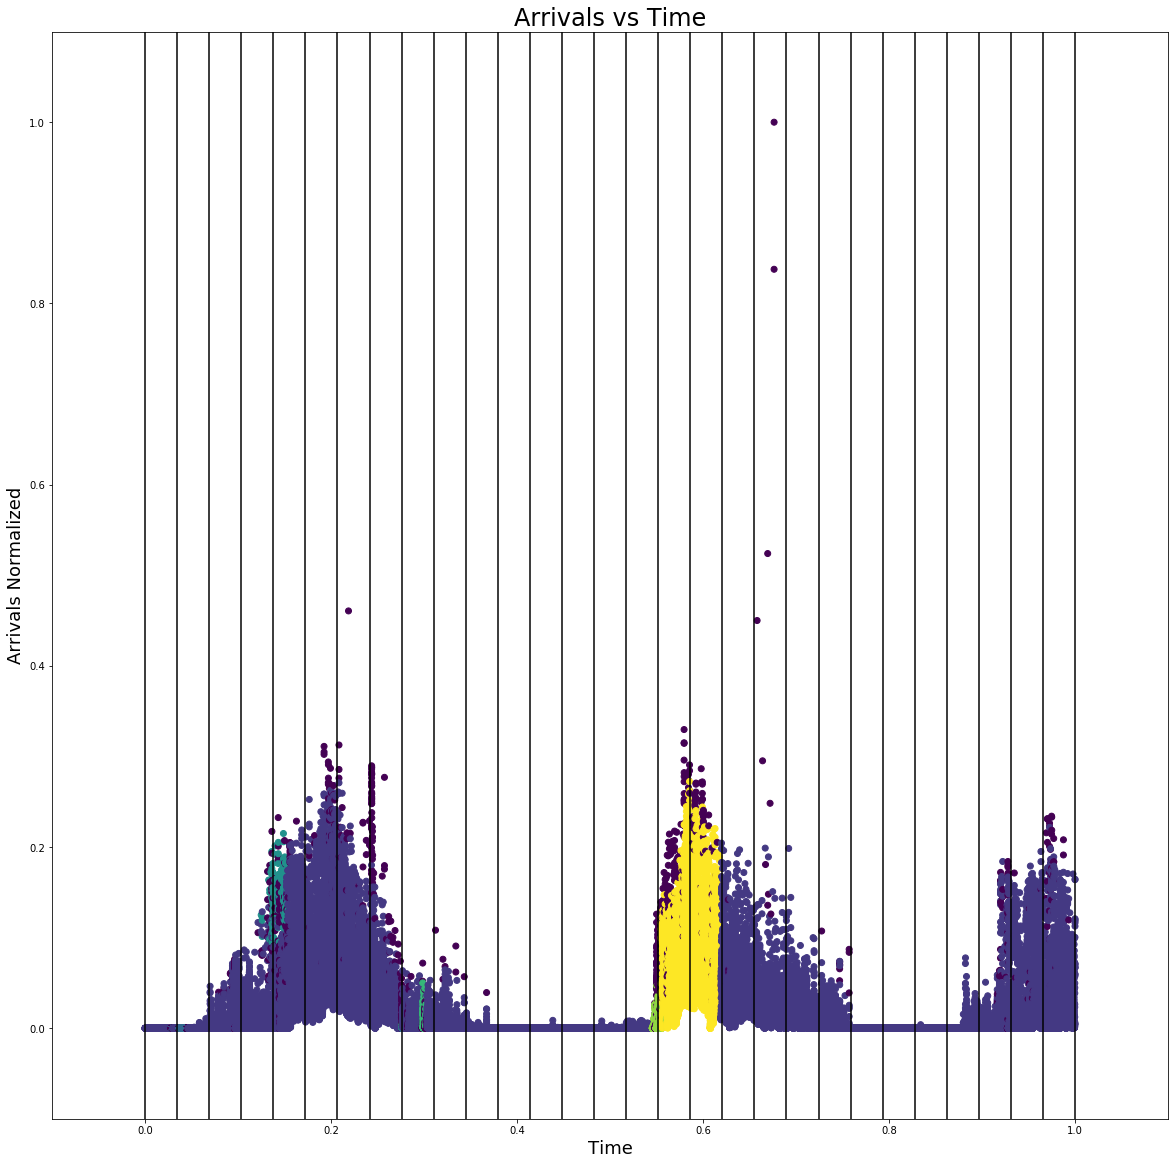

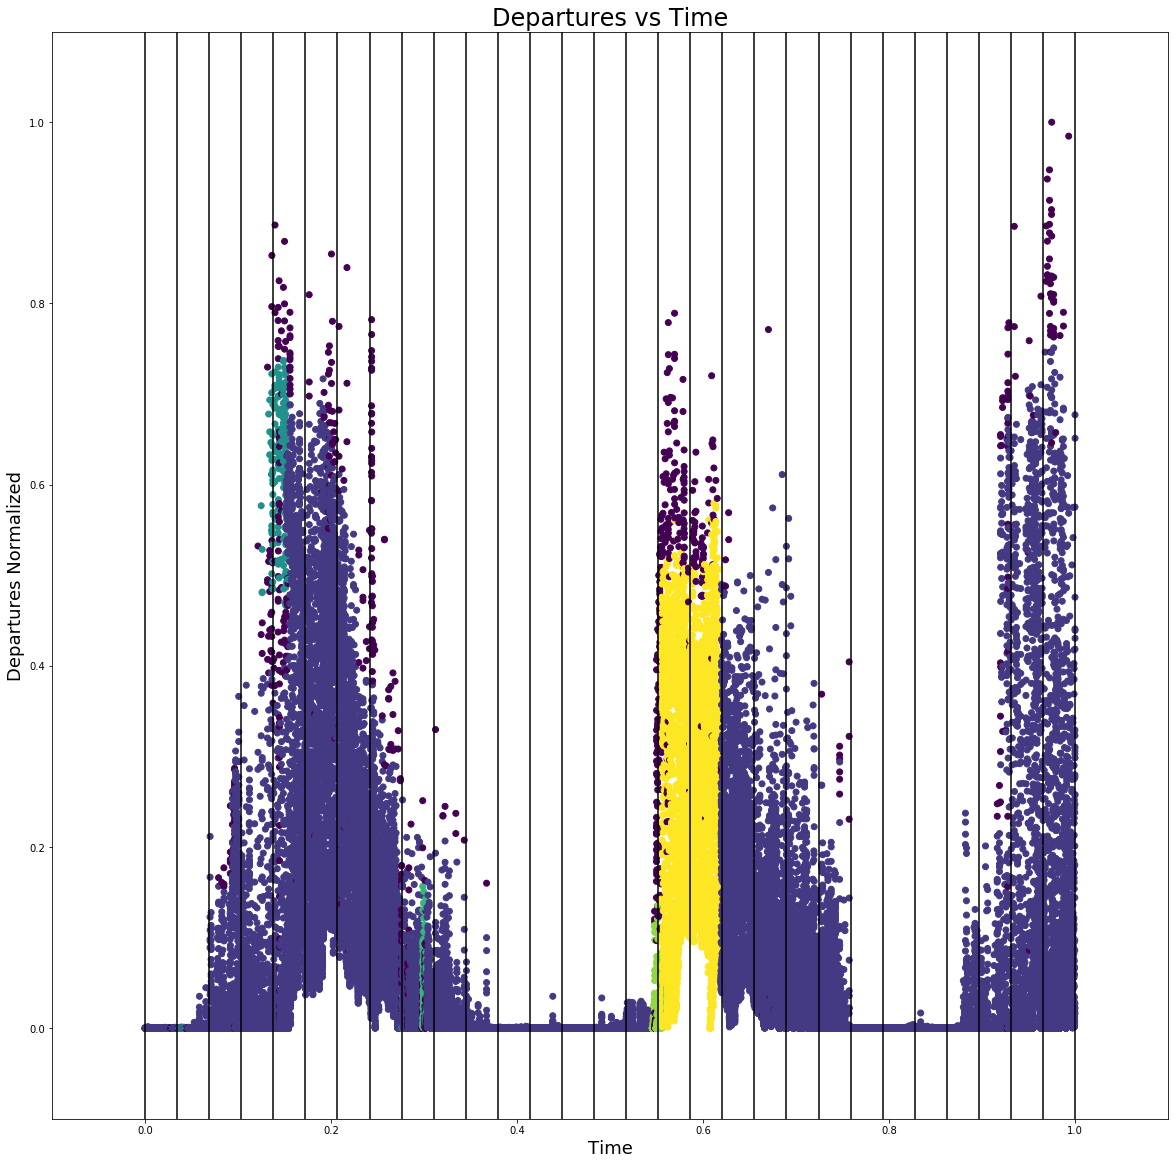

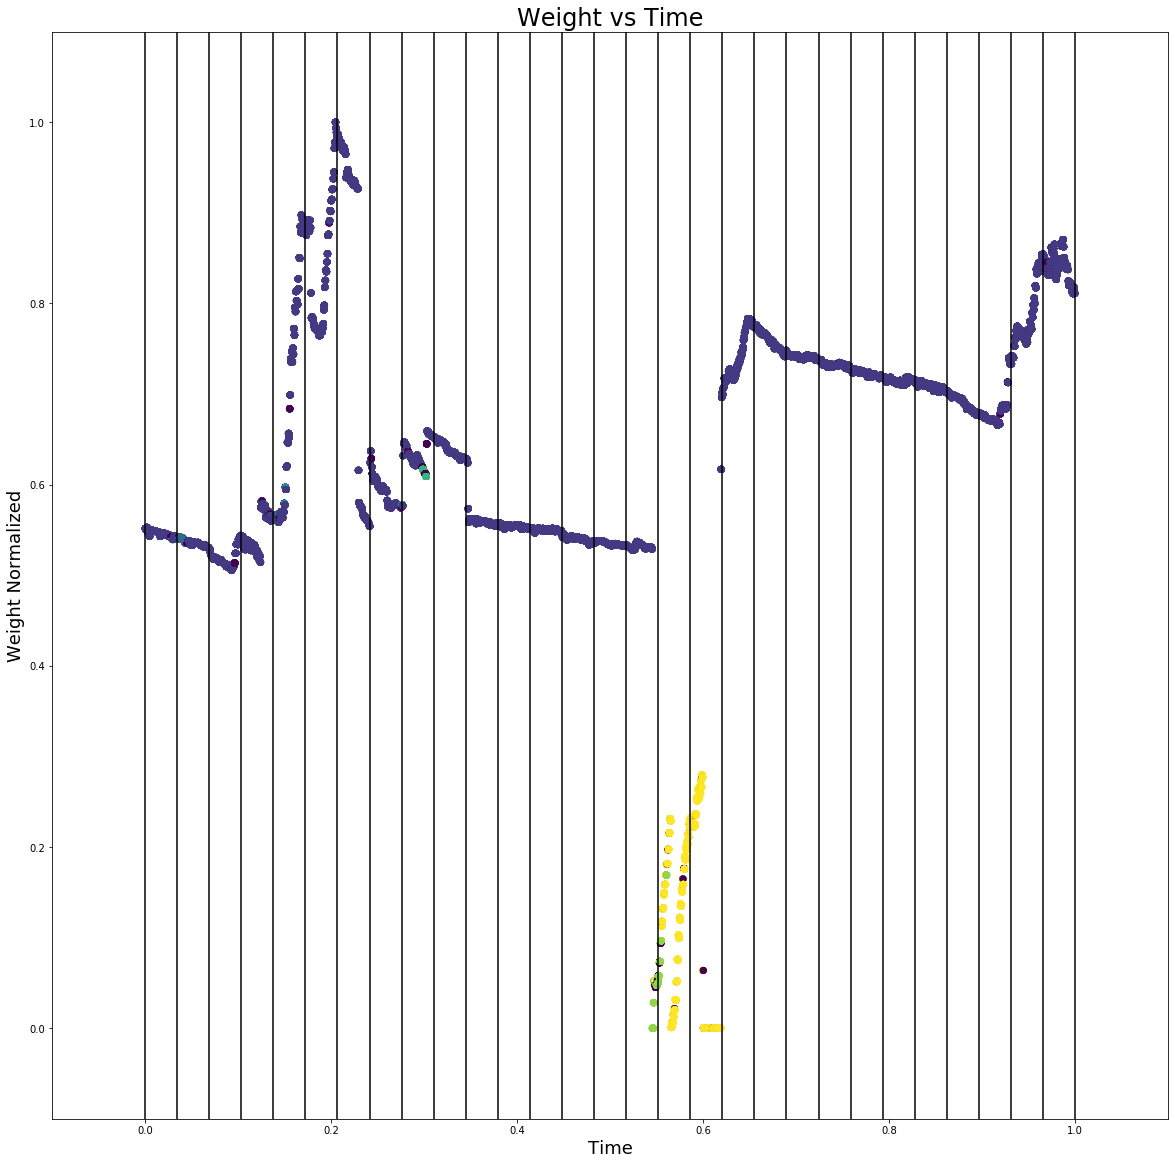

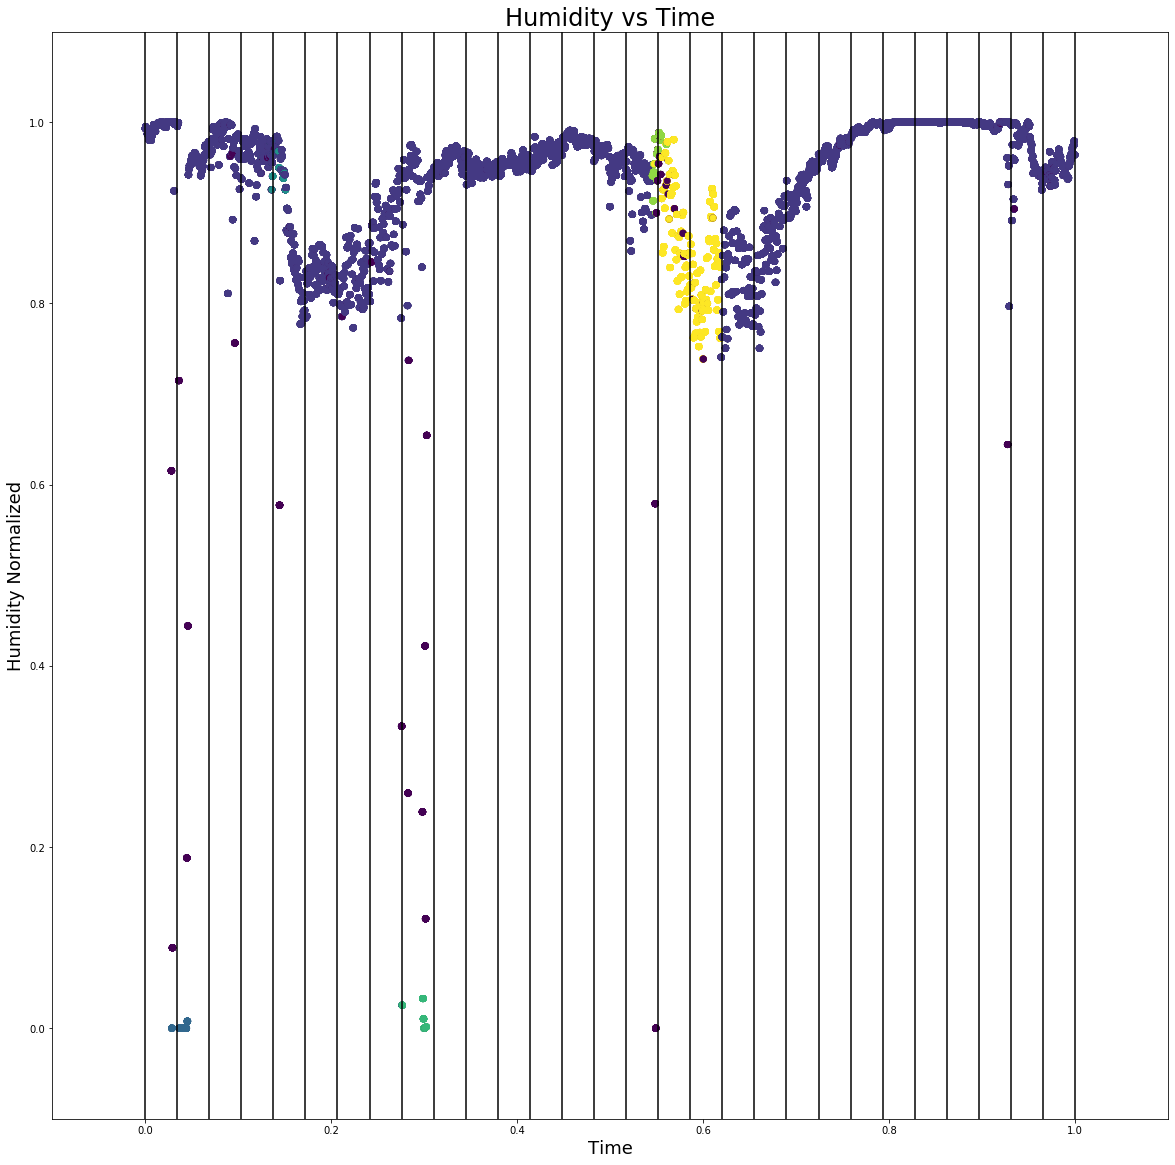

In [31]:
#Graph each attribute
for attribute, column in [['Flow', 5], ['Temperature', 4], ['Arrivals', 3], ['Departures', 2], ['Weight', 1], ['Humidity', 0]]:
    plt.figure(figsize=(20,20))
    plt.title(f'{attribute} vs Time', fontsize=24)
    plt.ylabel(f'{attribute} Normalized', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    for i in range(30):
        plt.axvline(x=i/29, c='black')
    plt.xlim(right=1.1)
    plt.xlim(left=-0.1)
    plt.ylim(top=1.1)
    plt.ylim(bottom=-0.1)
    plt.scatter(timestamps, X[:,column], c=labels)

Now we will graph each individual cluster by its label for each attribute by time. Note that lable -1 is outliers and label 0 is what we classify as normal behavior. We also classified label 4 as having the occurence of a harvest where honey was removed from the hive willingly.

C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


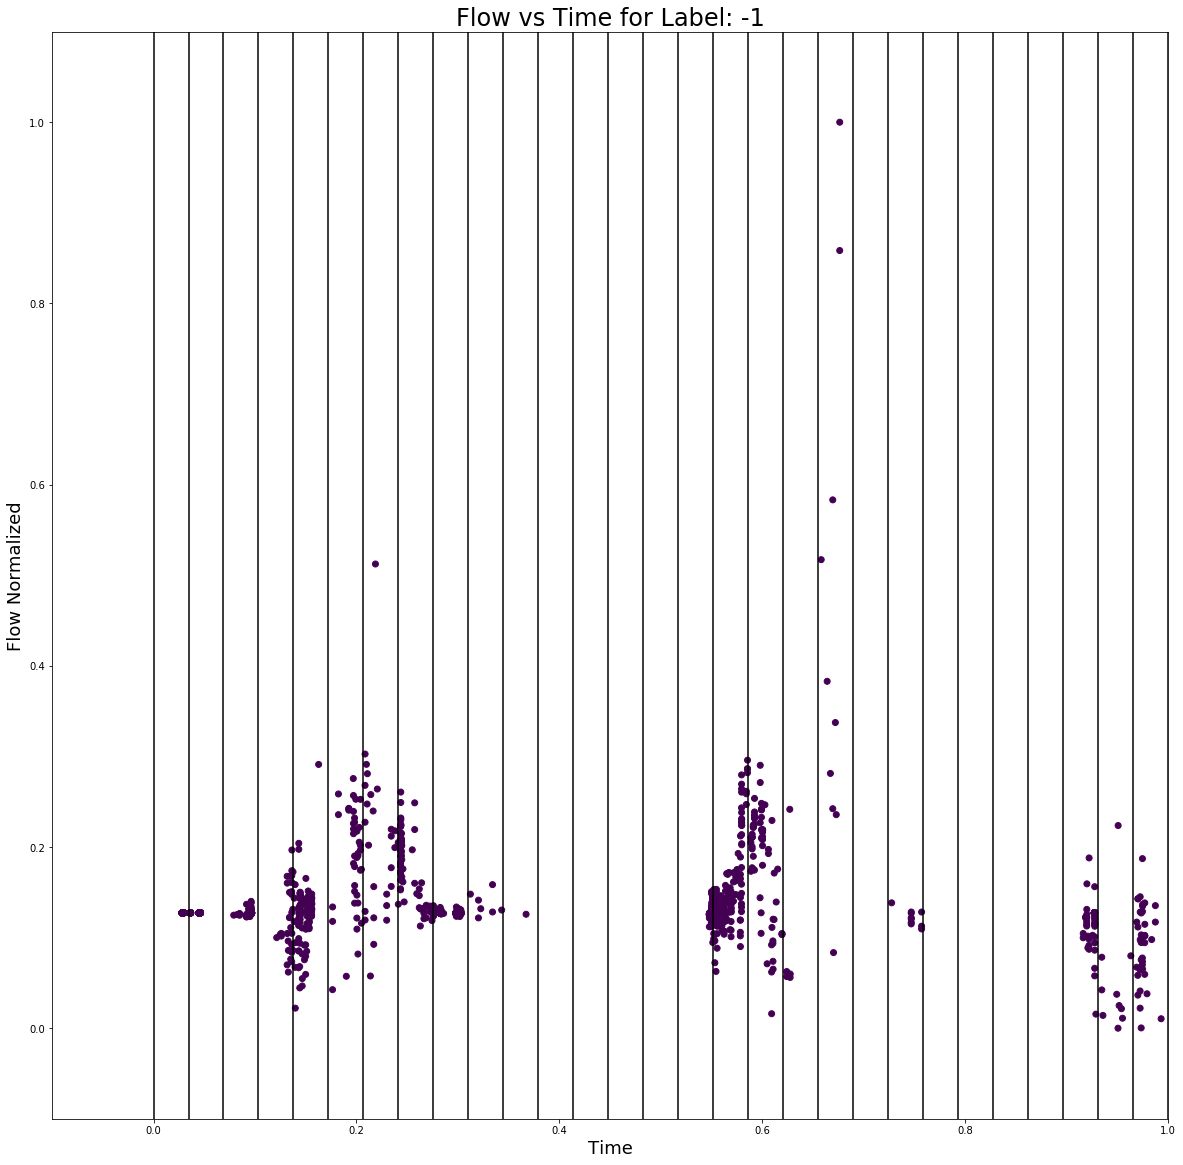

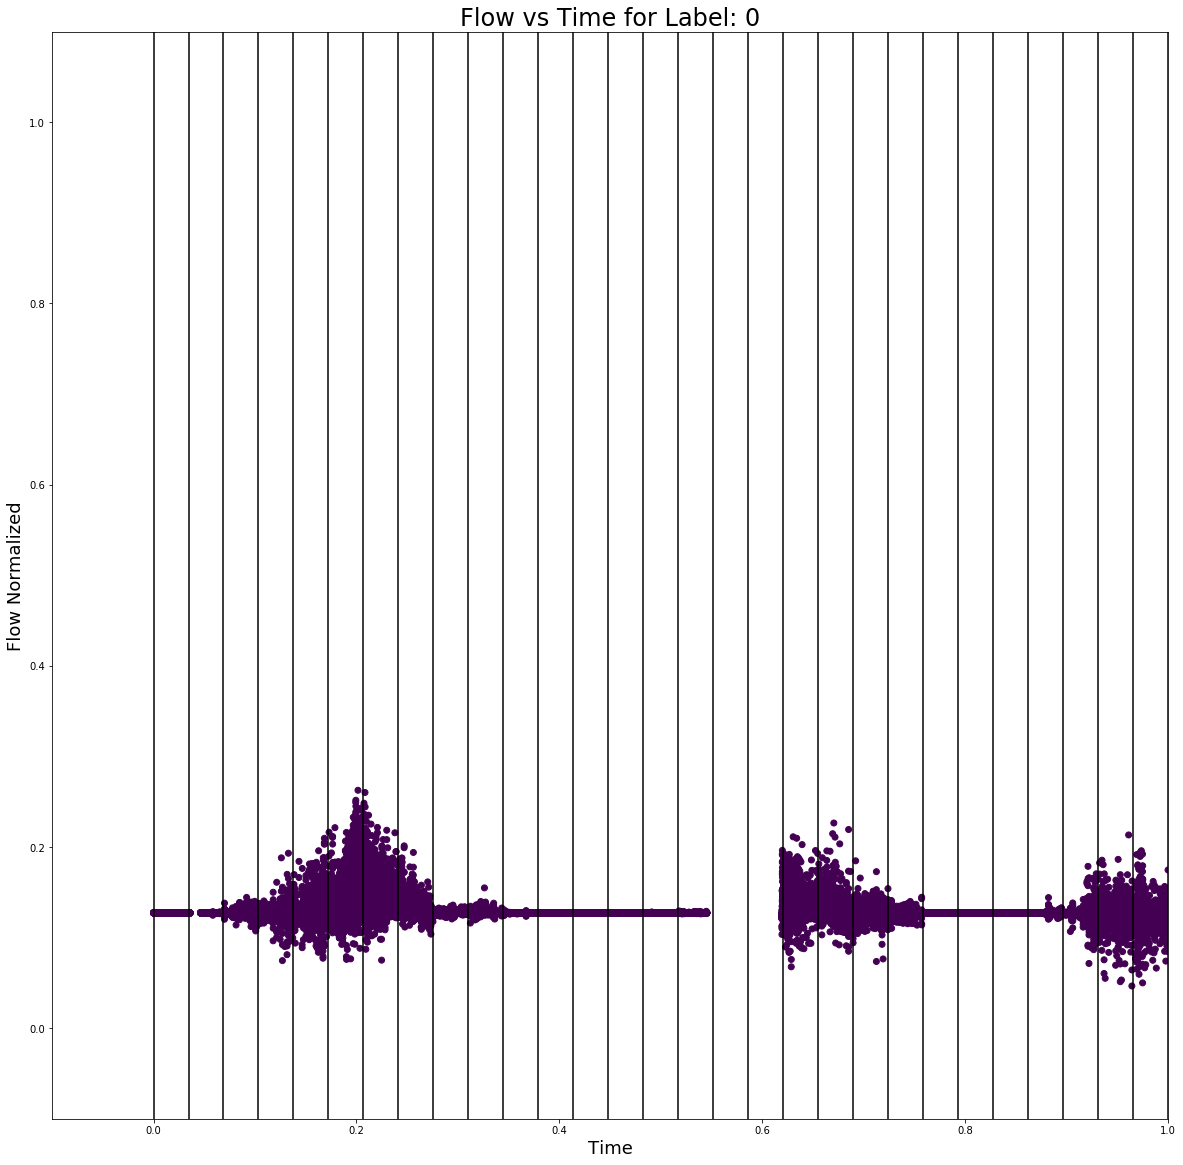

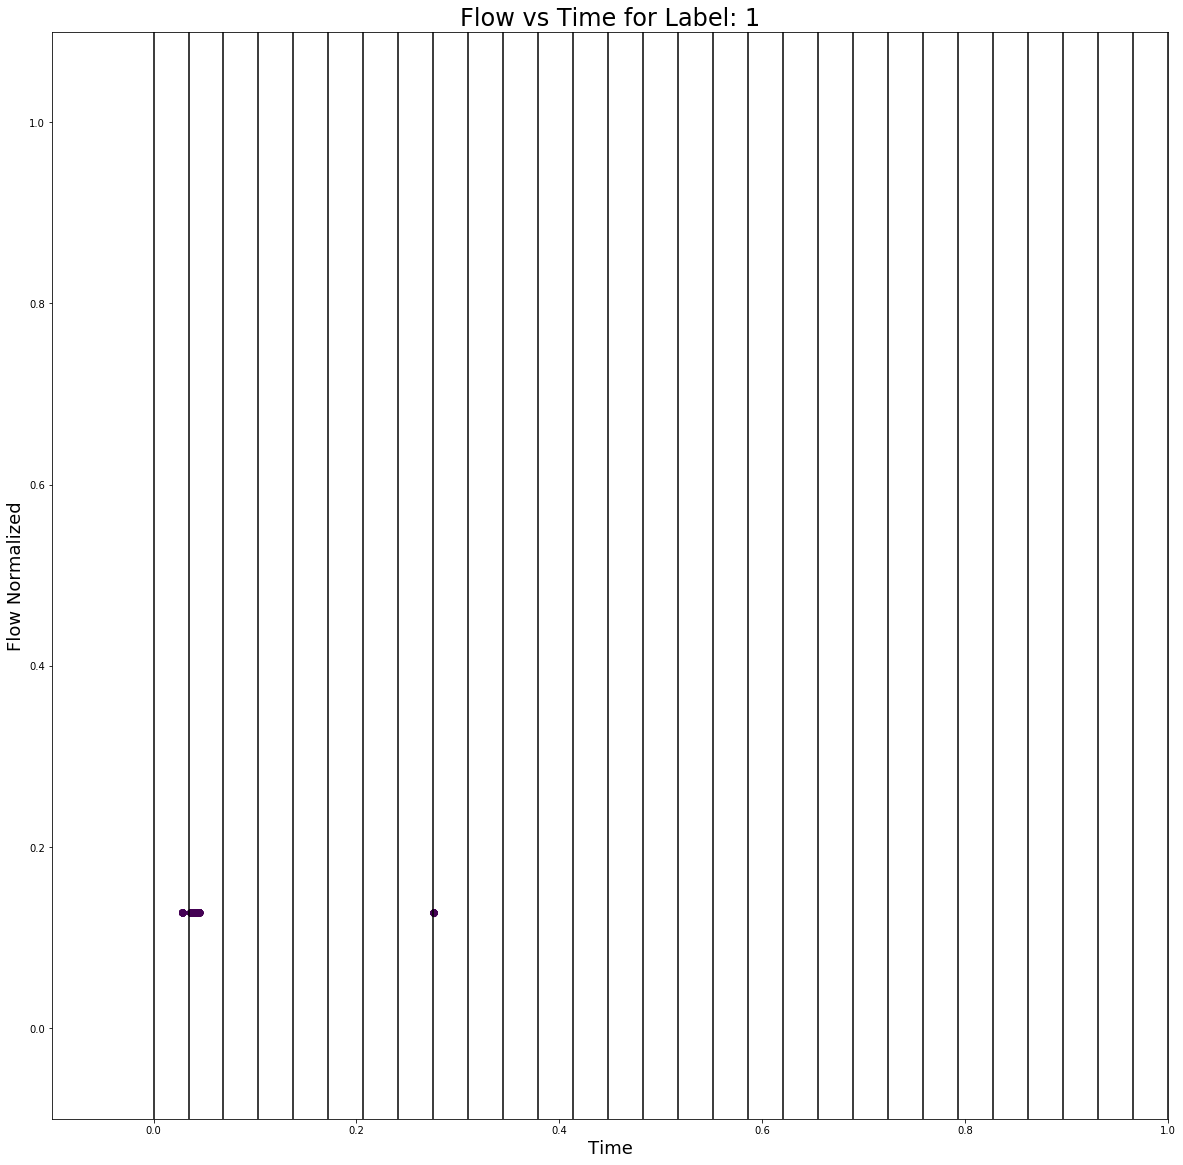

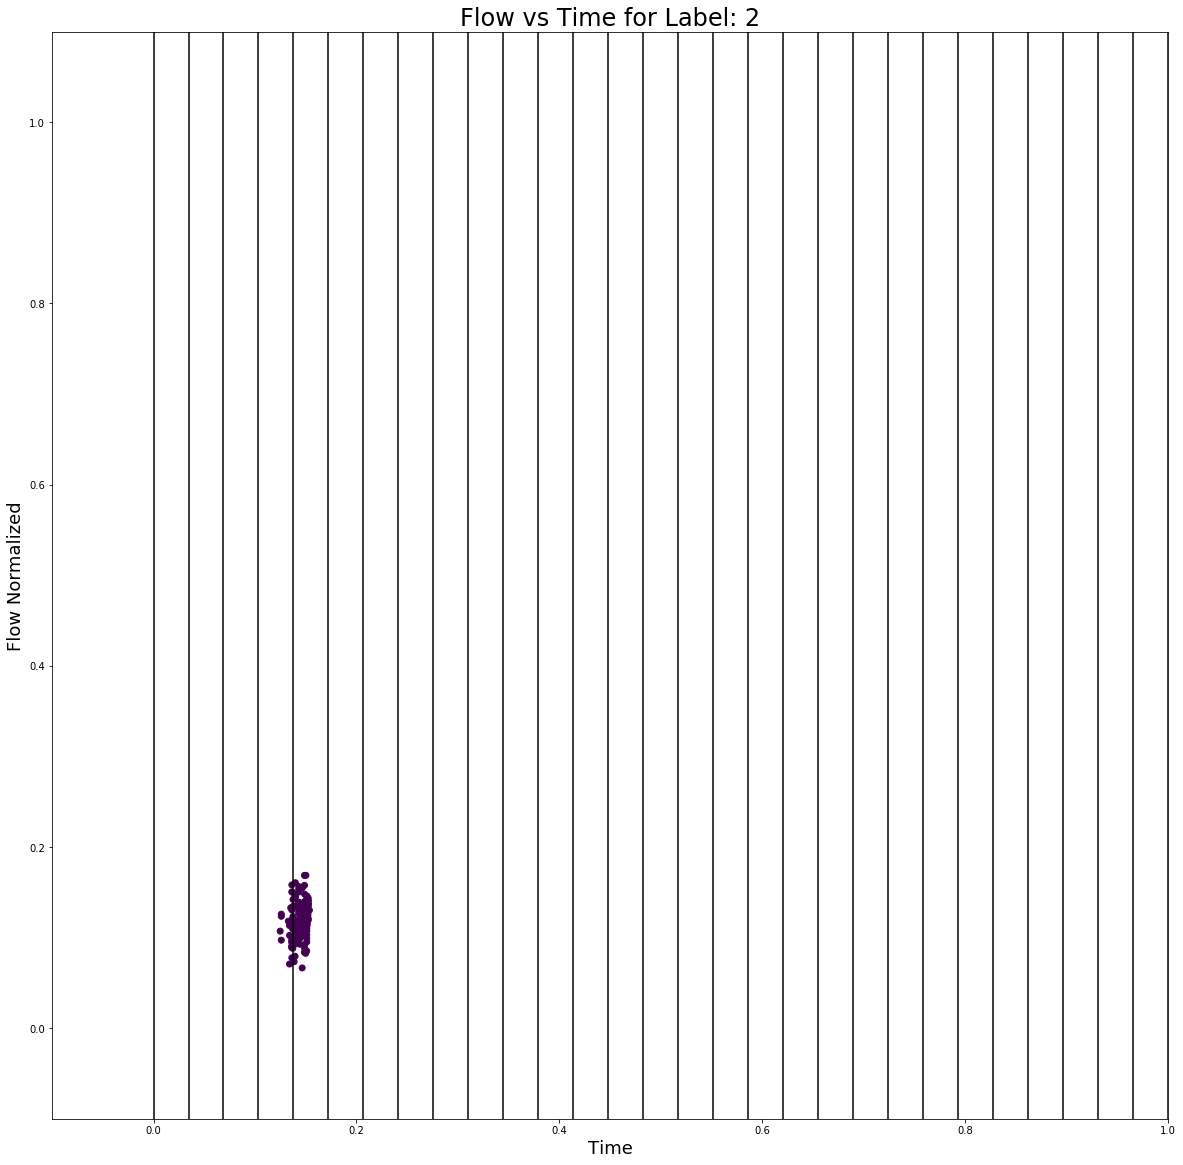

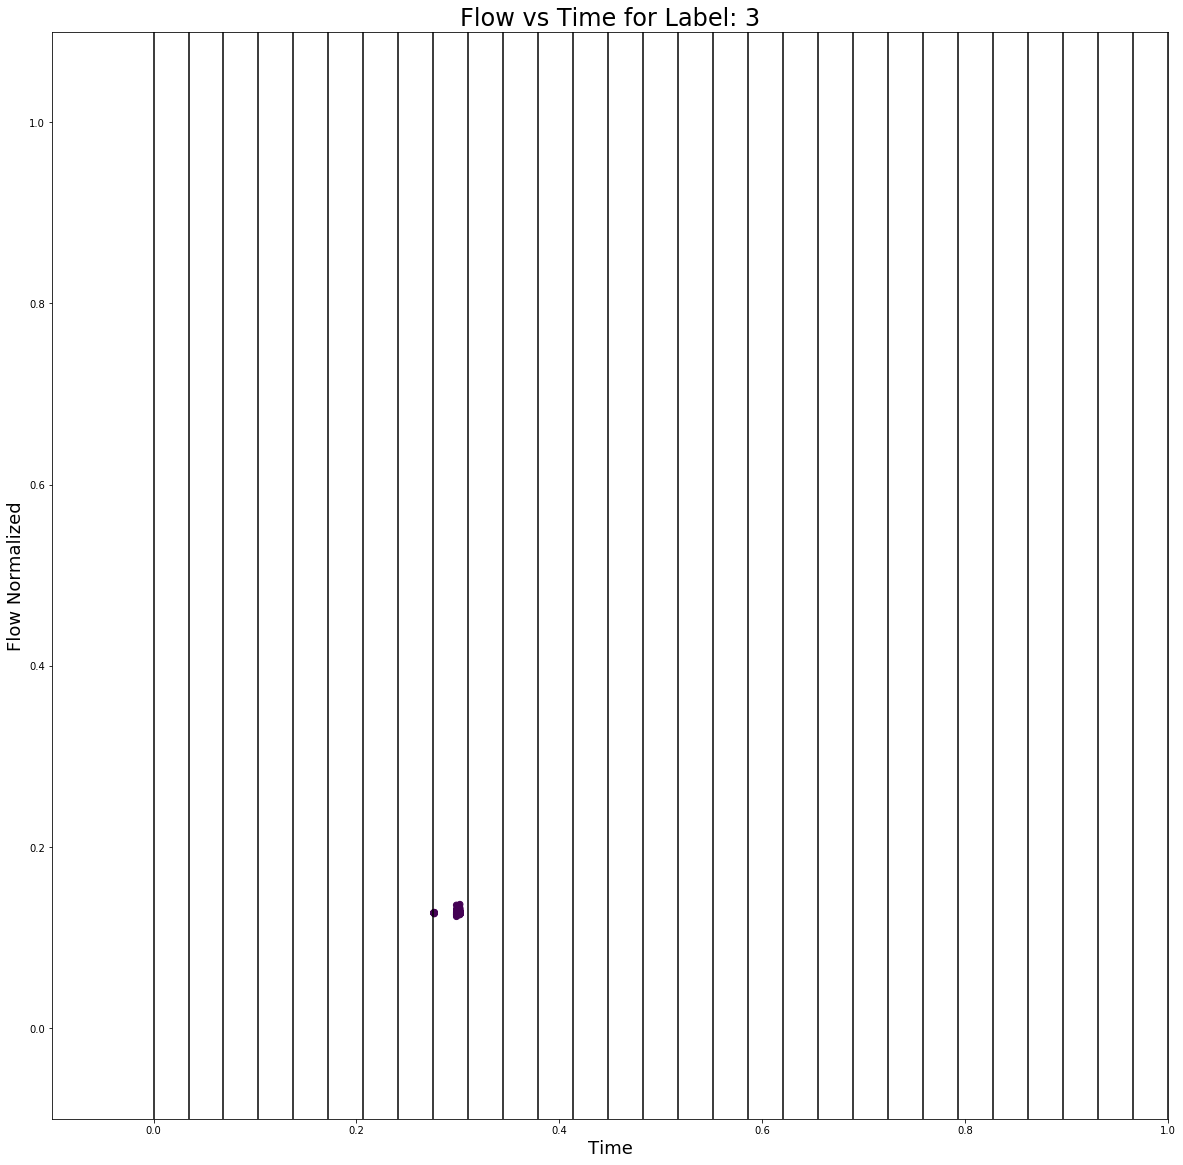

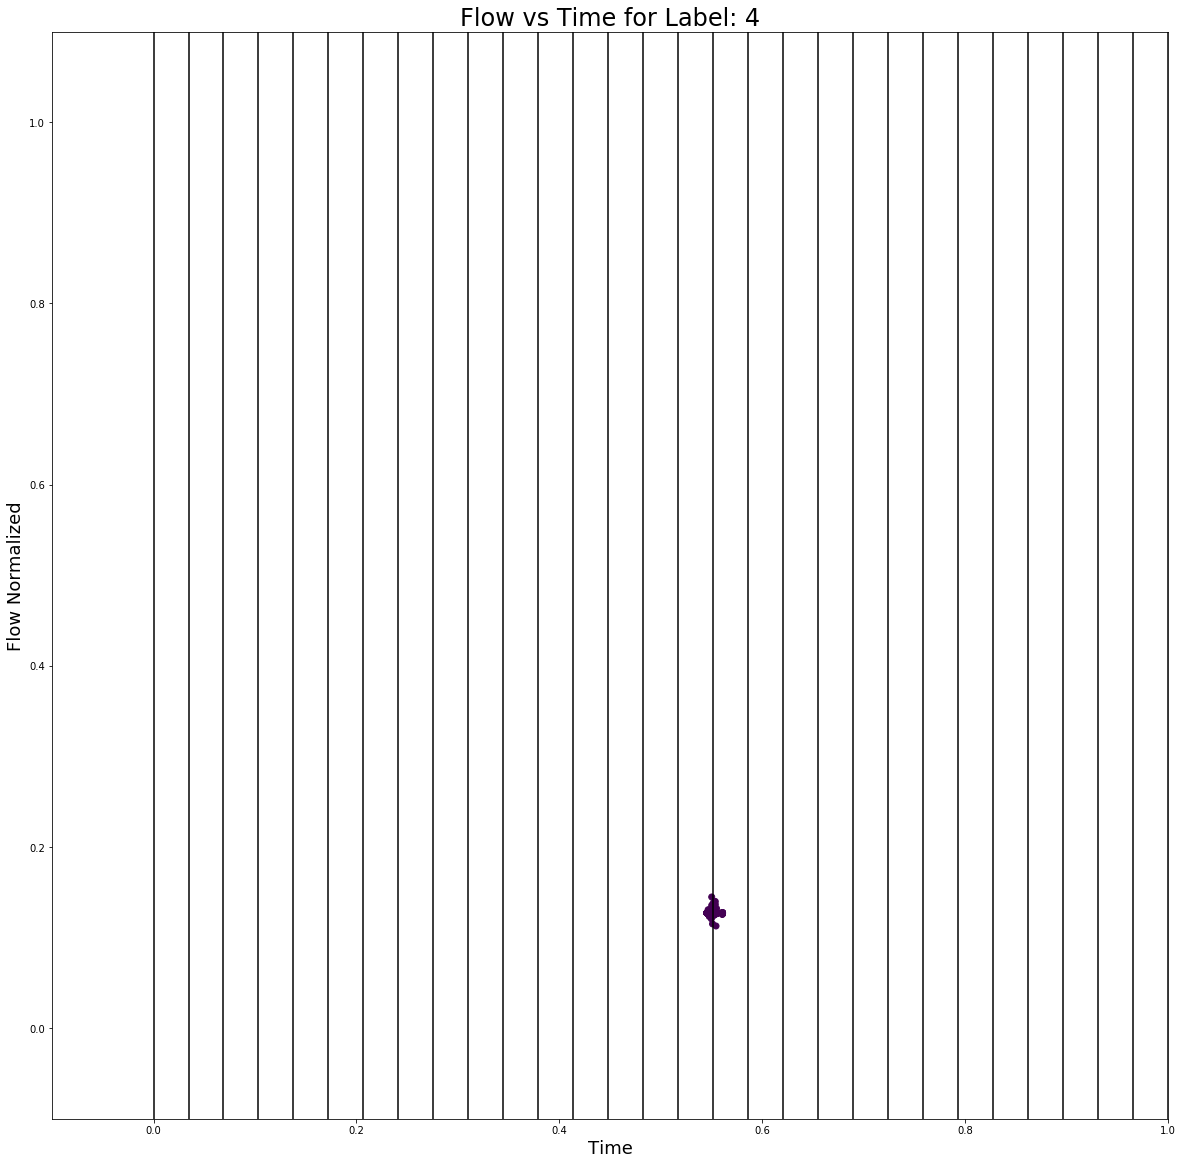

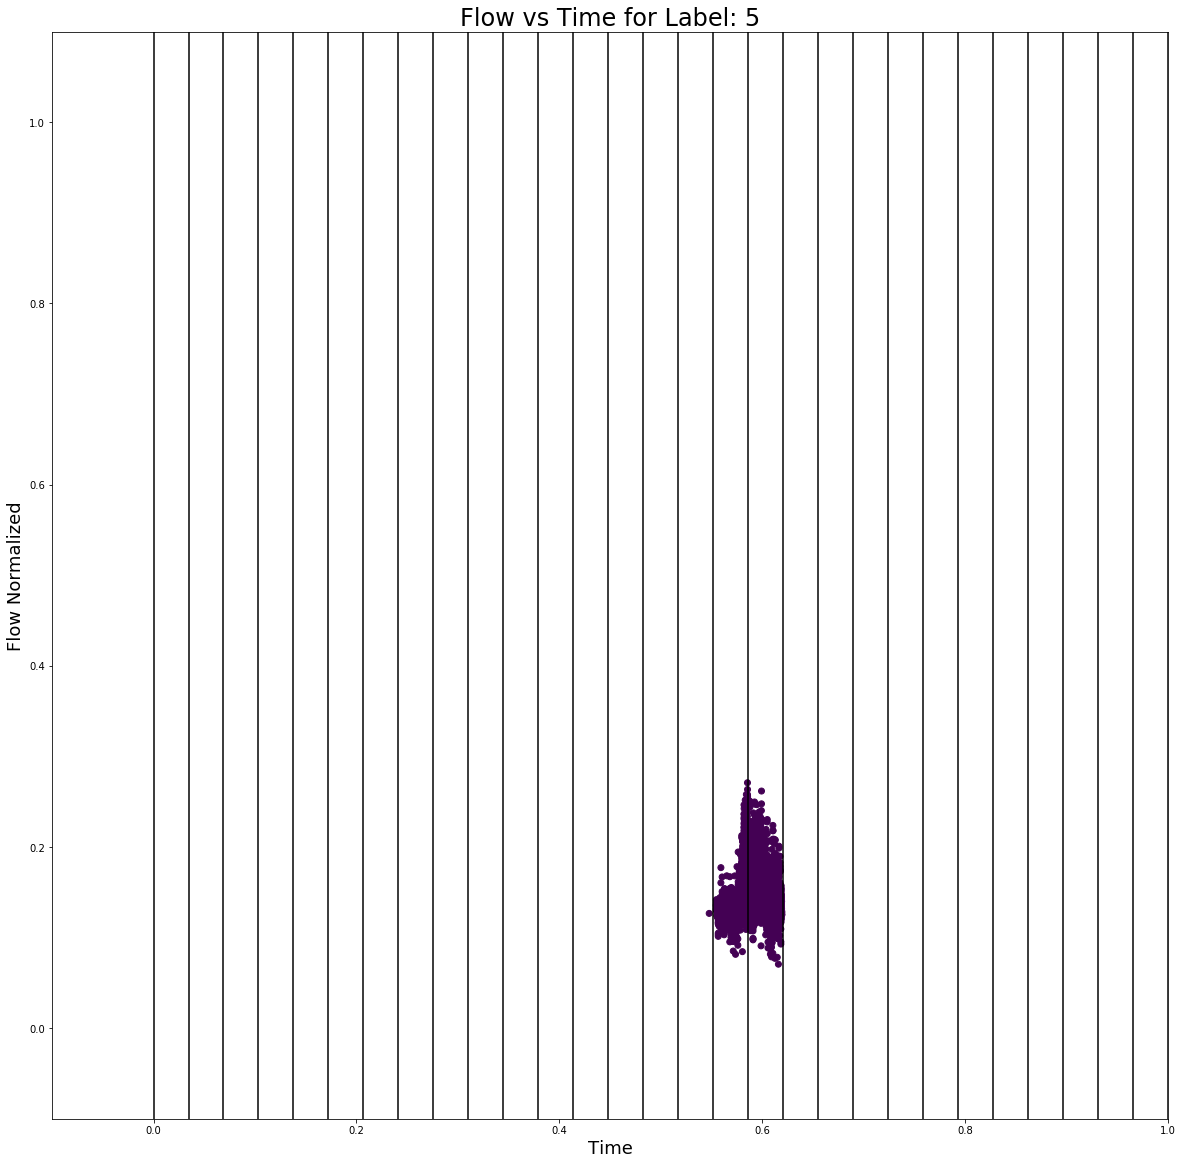

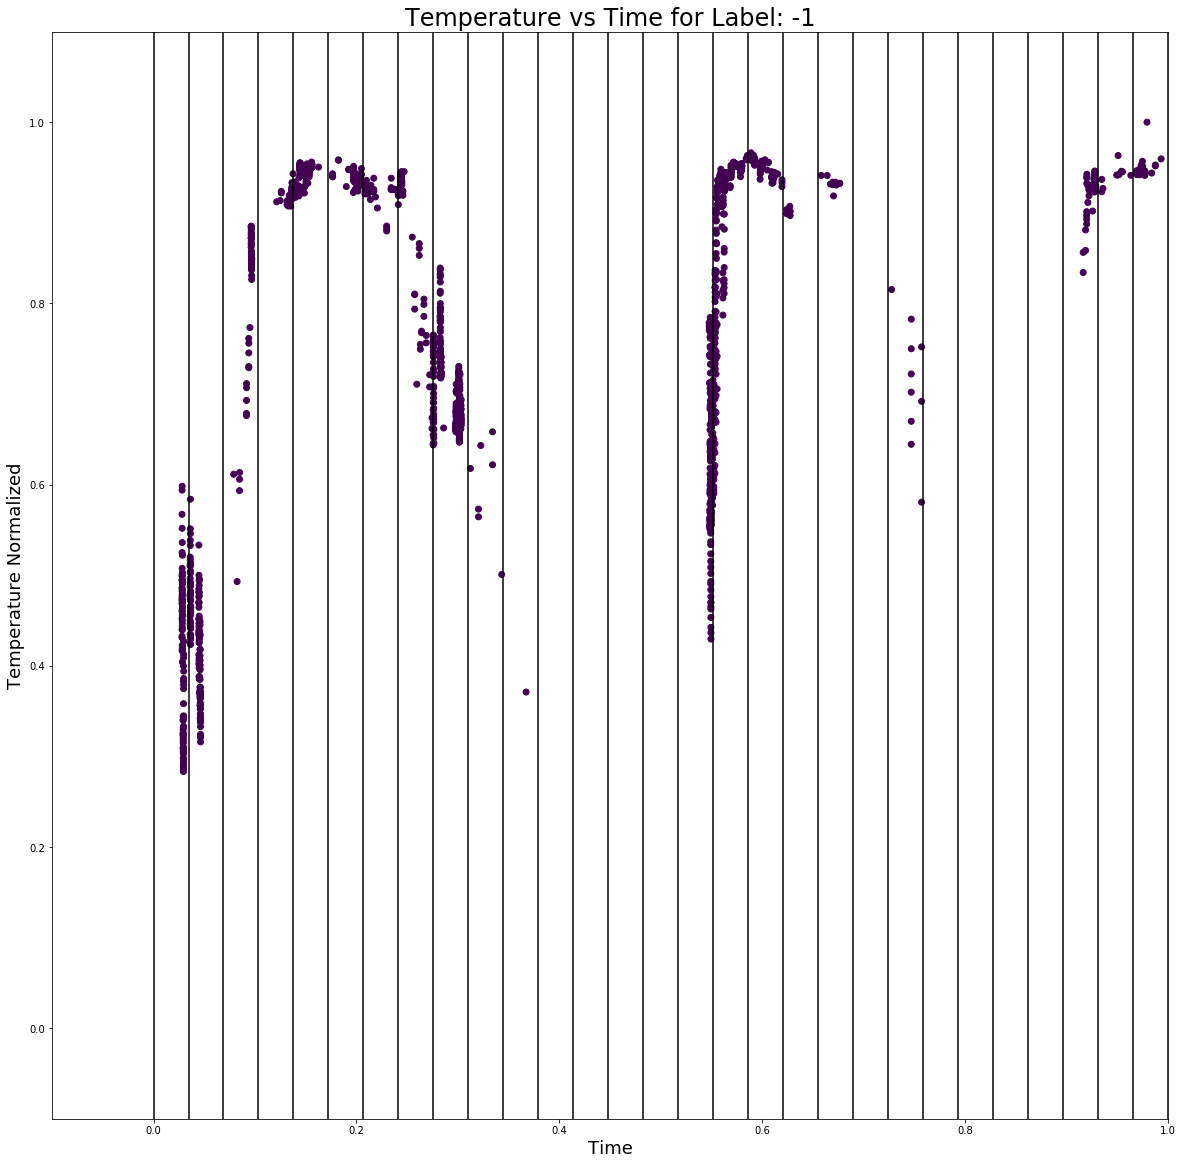

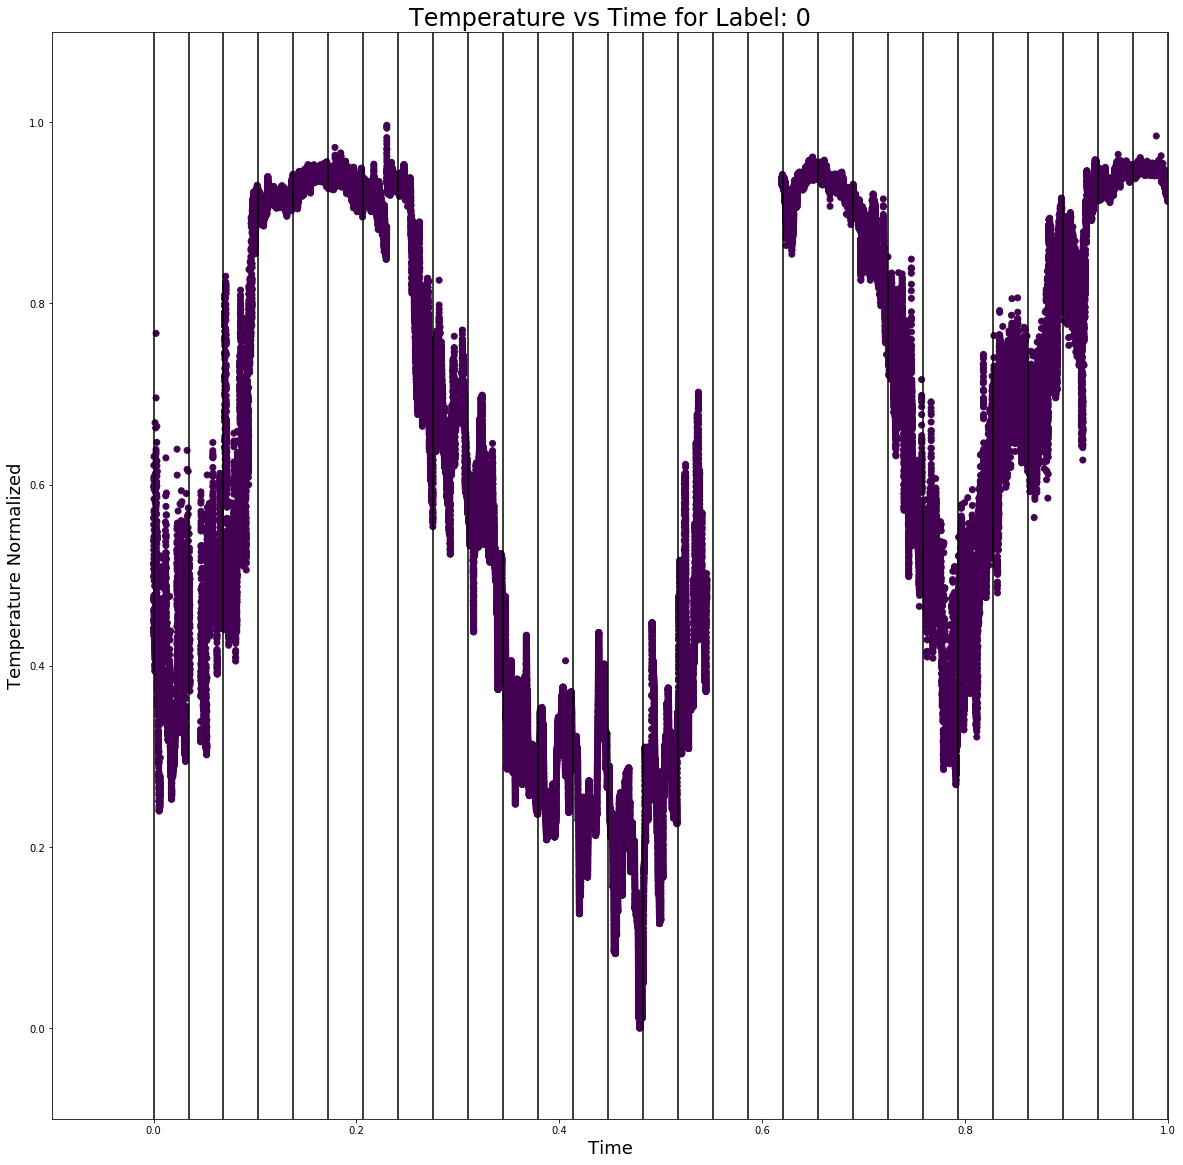

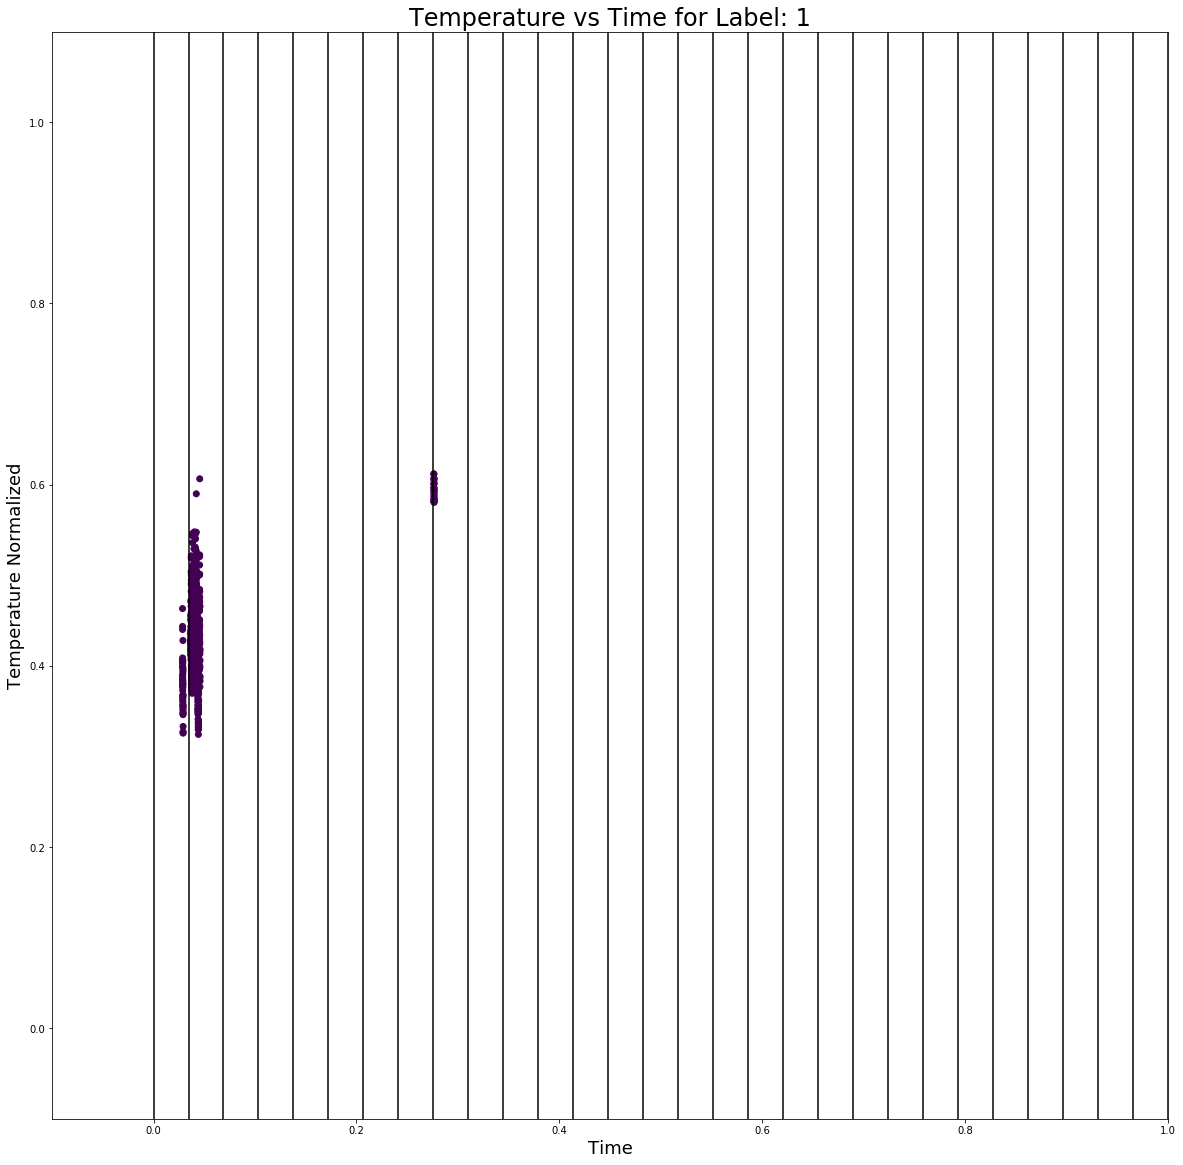

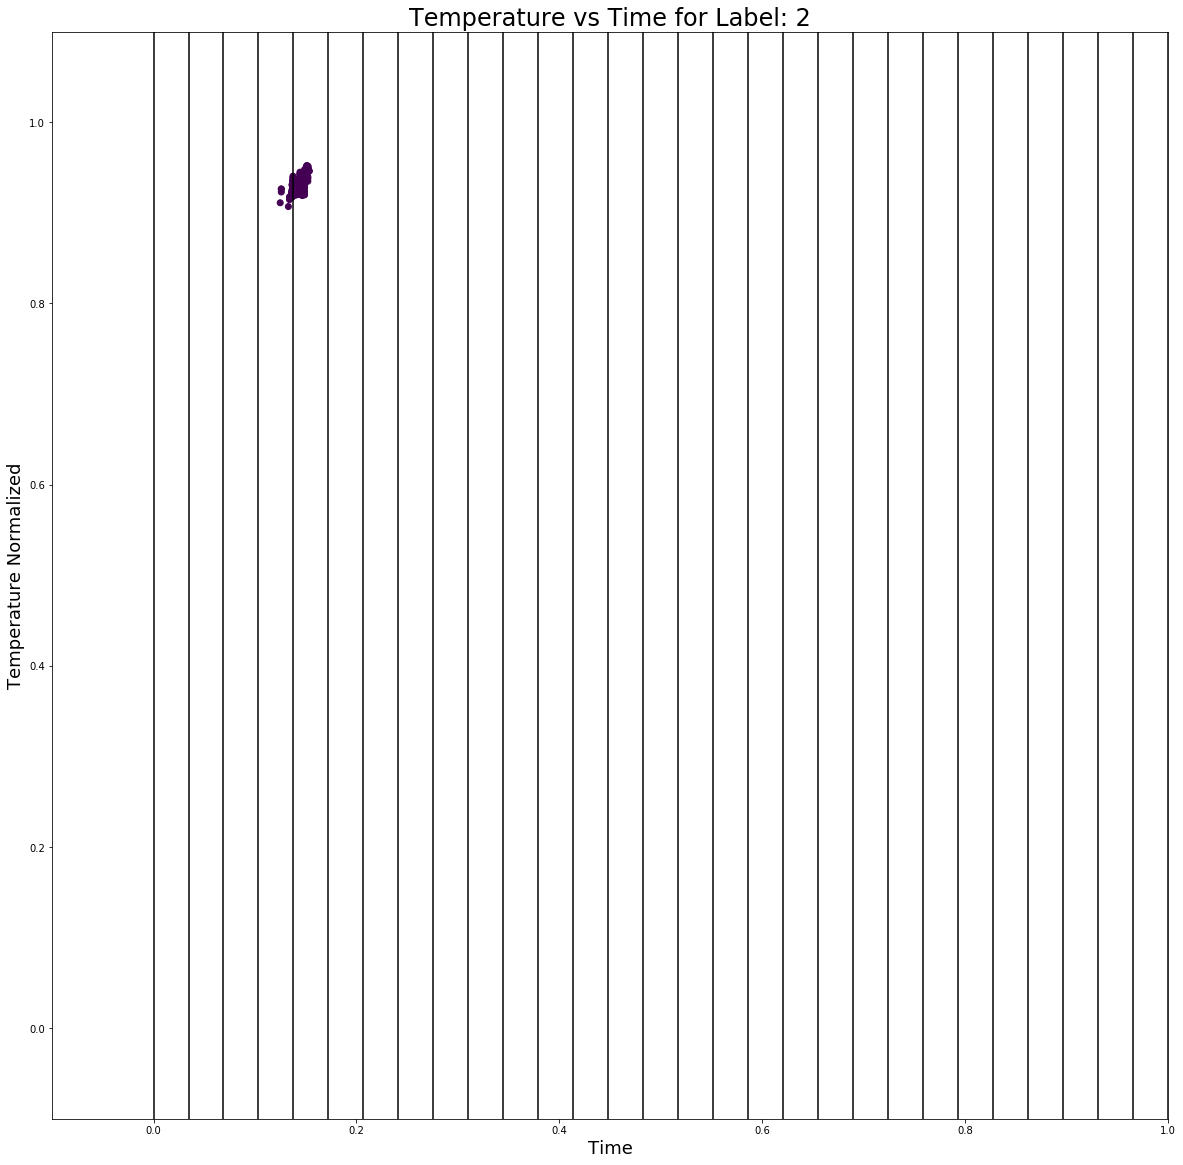

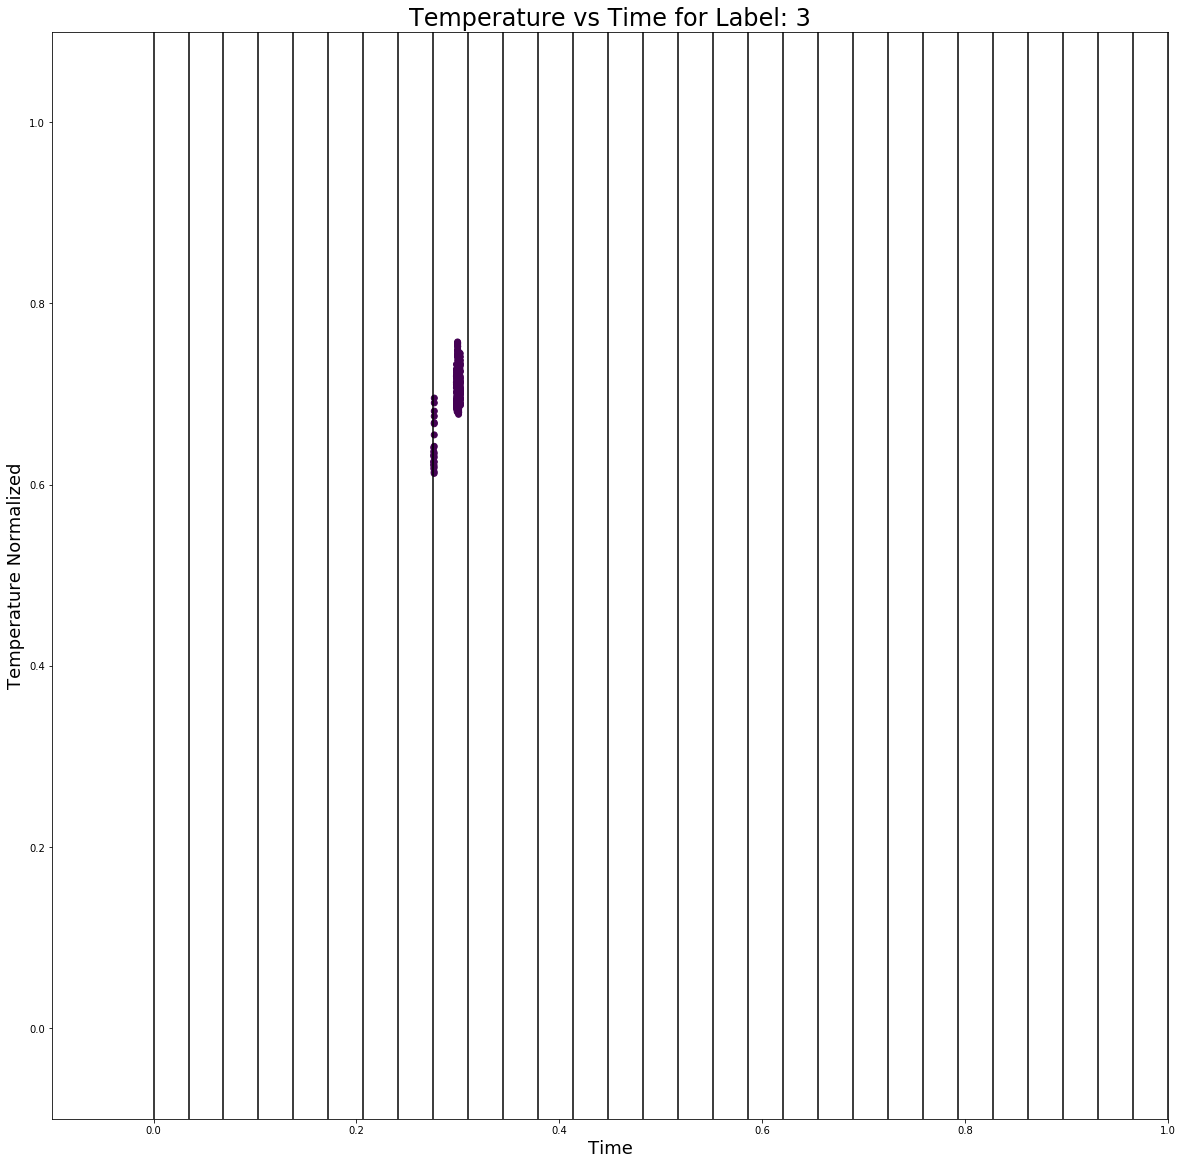

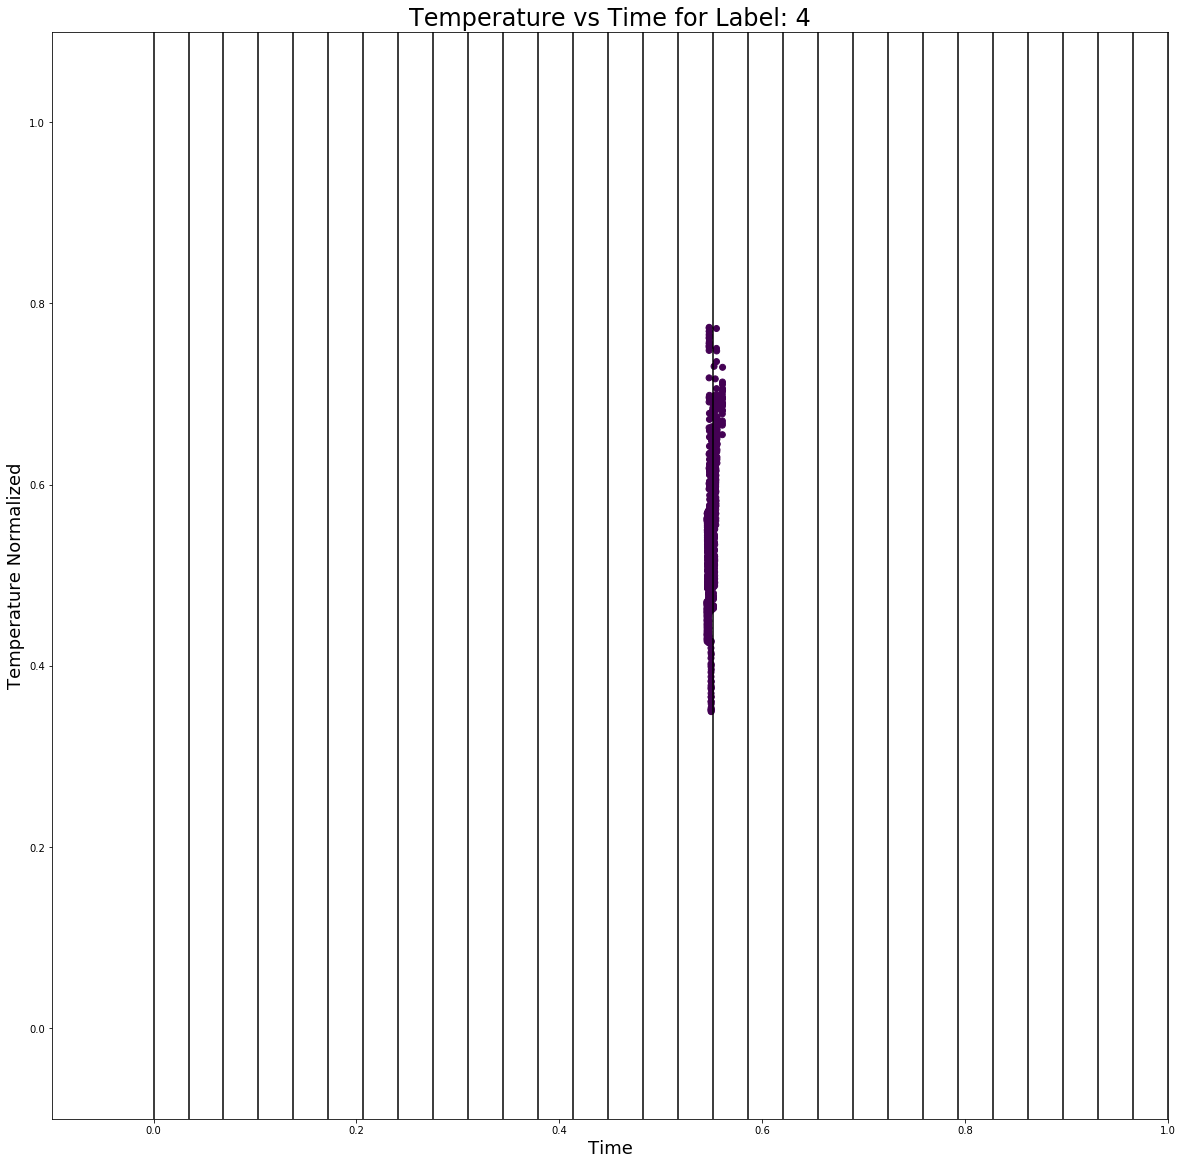

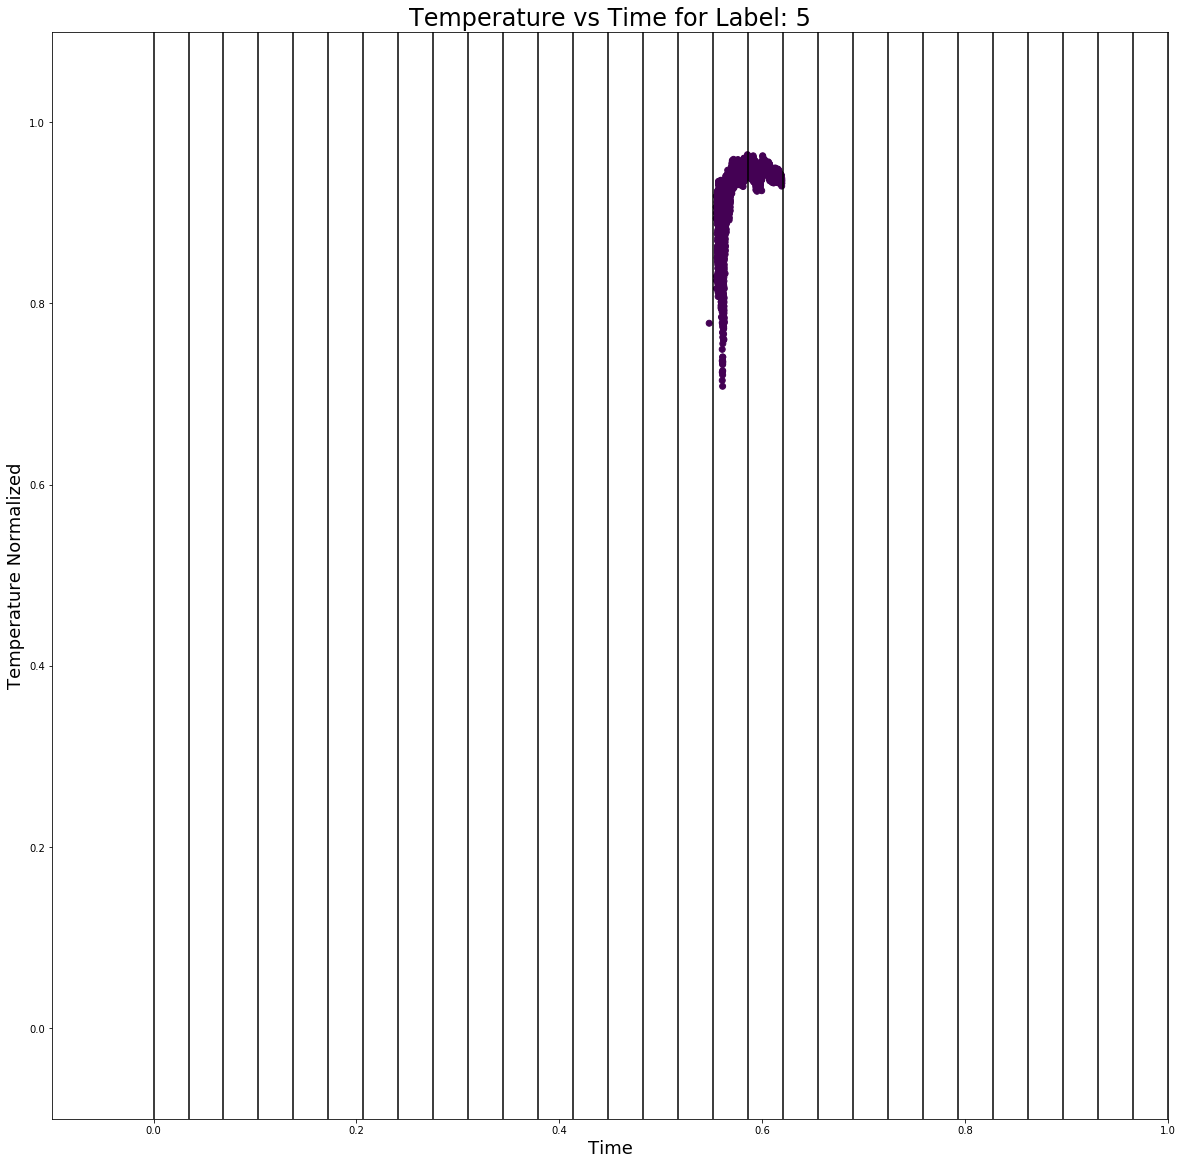

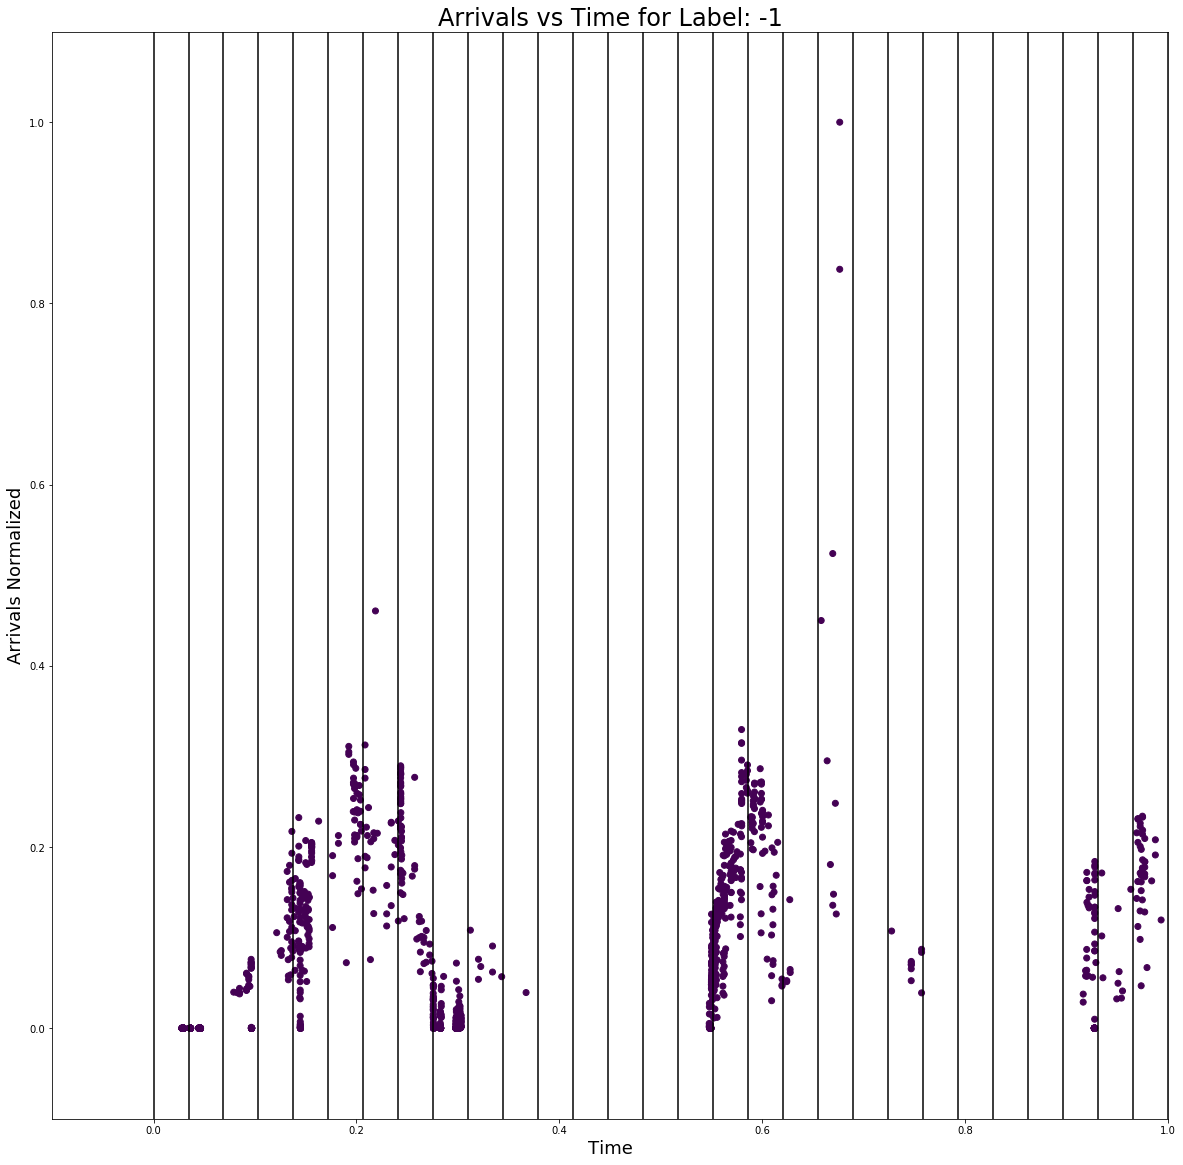

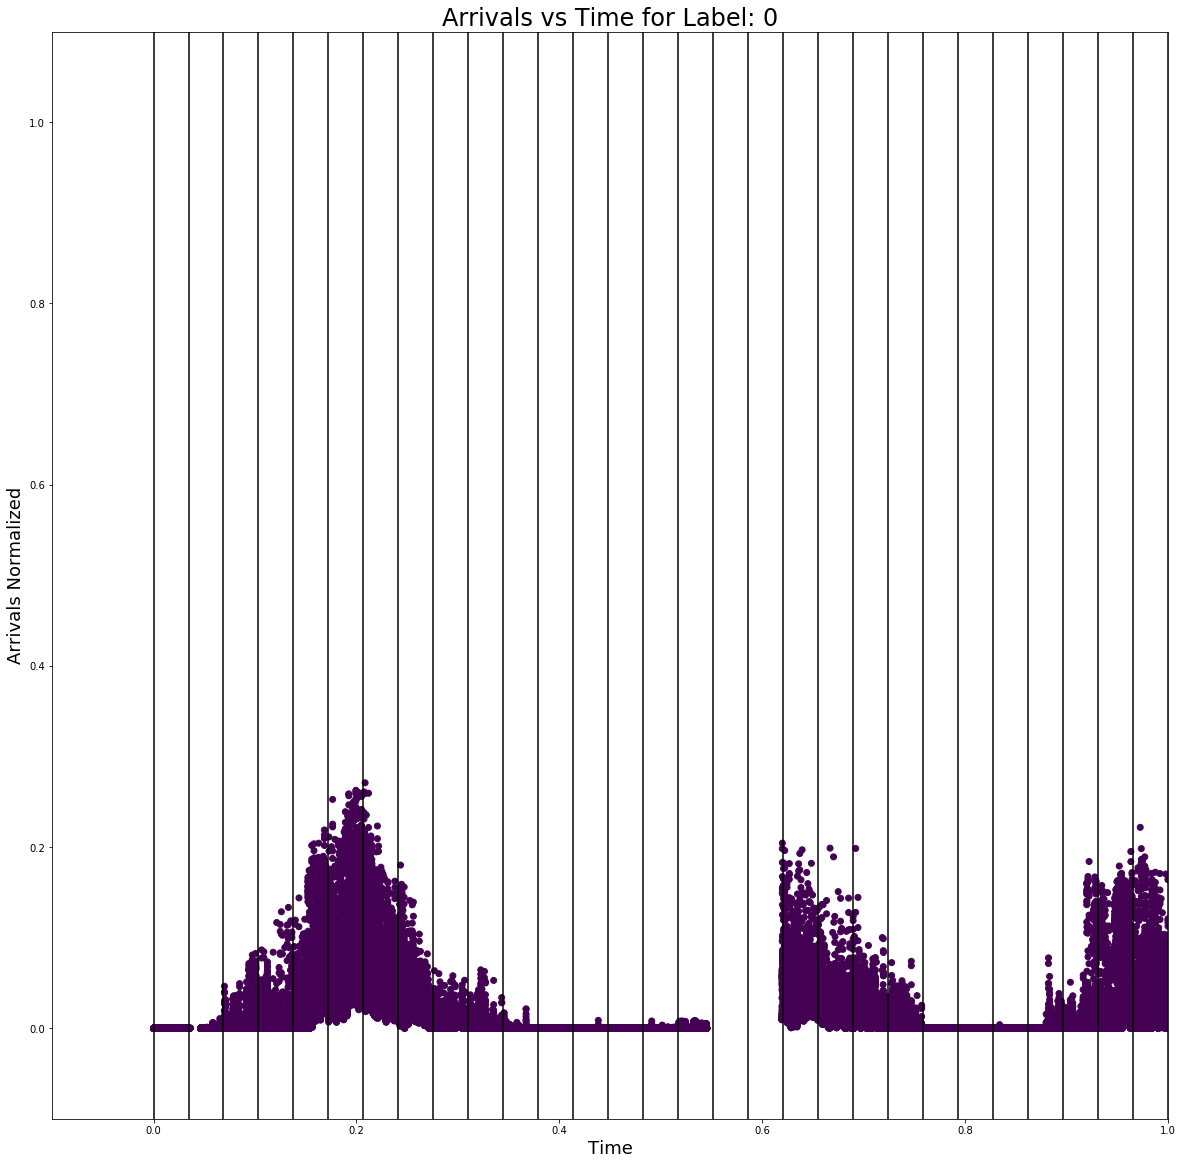

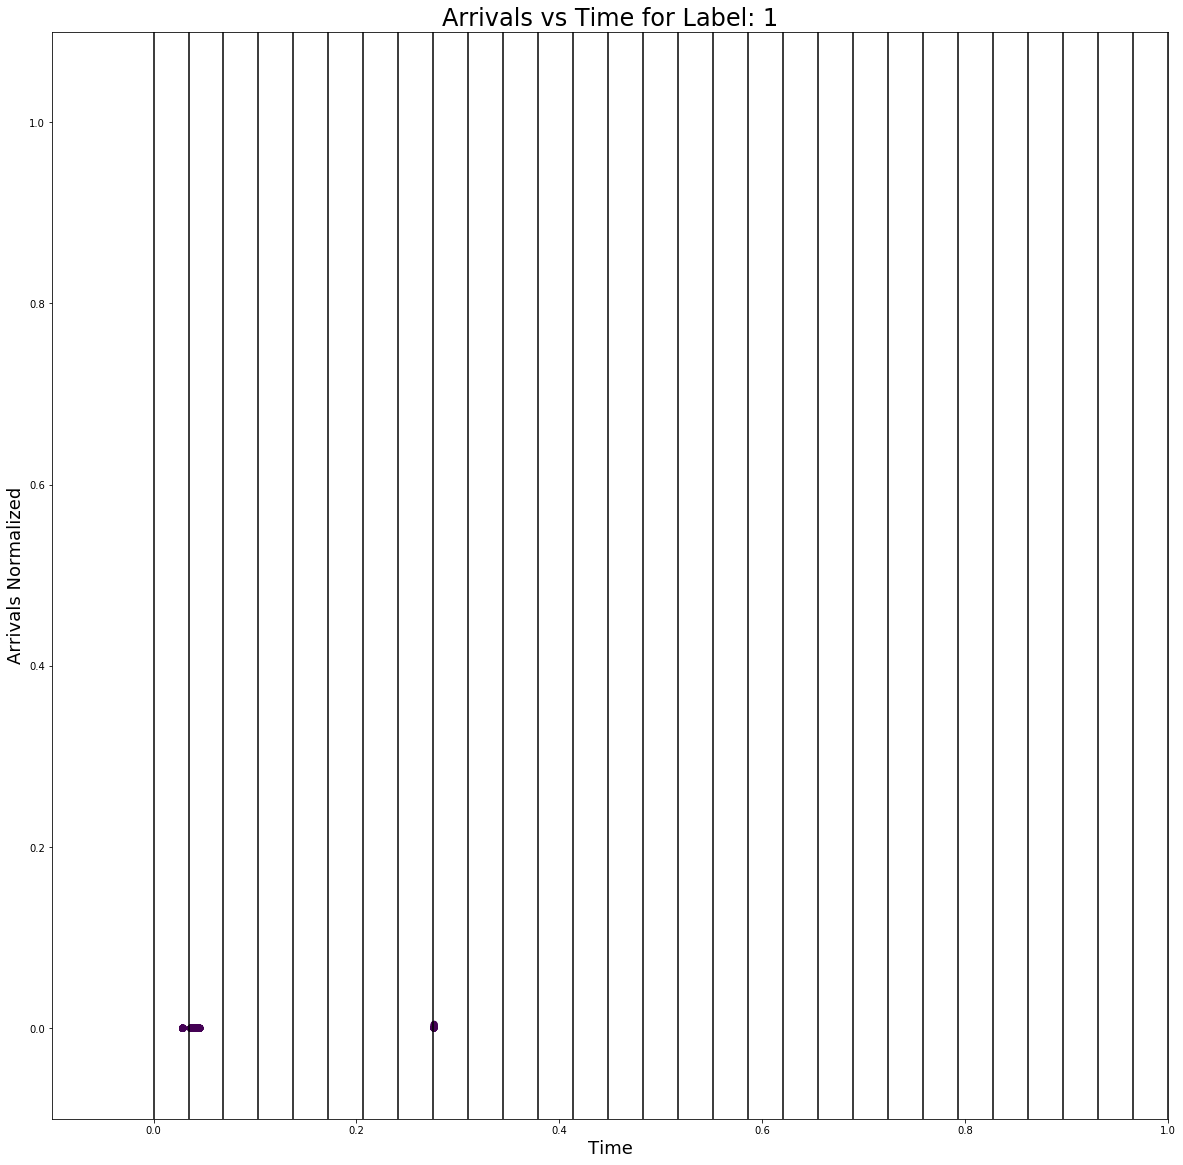

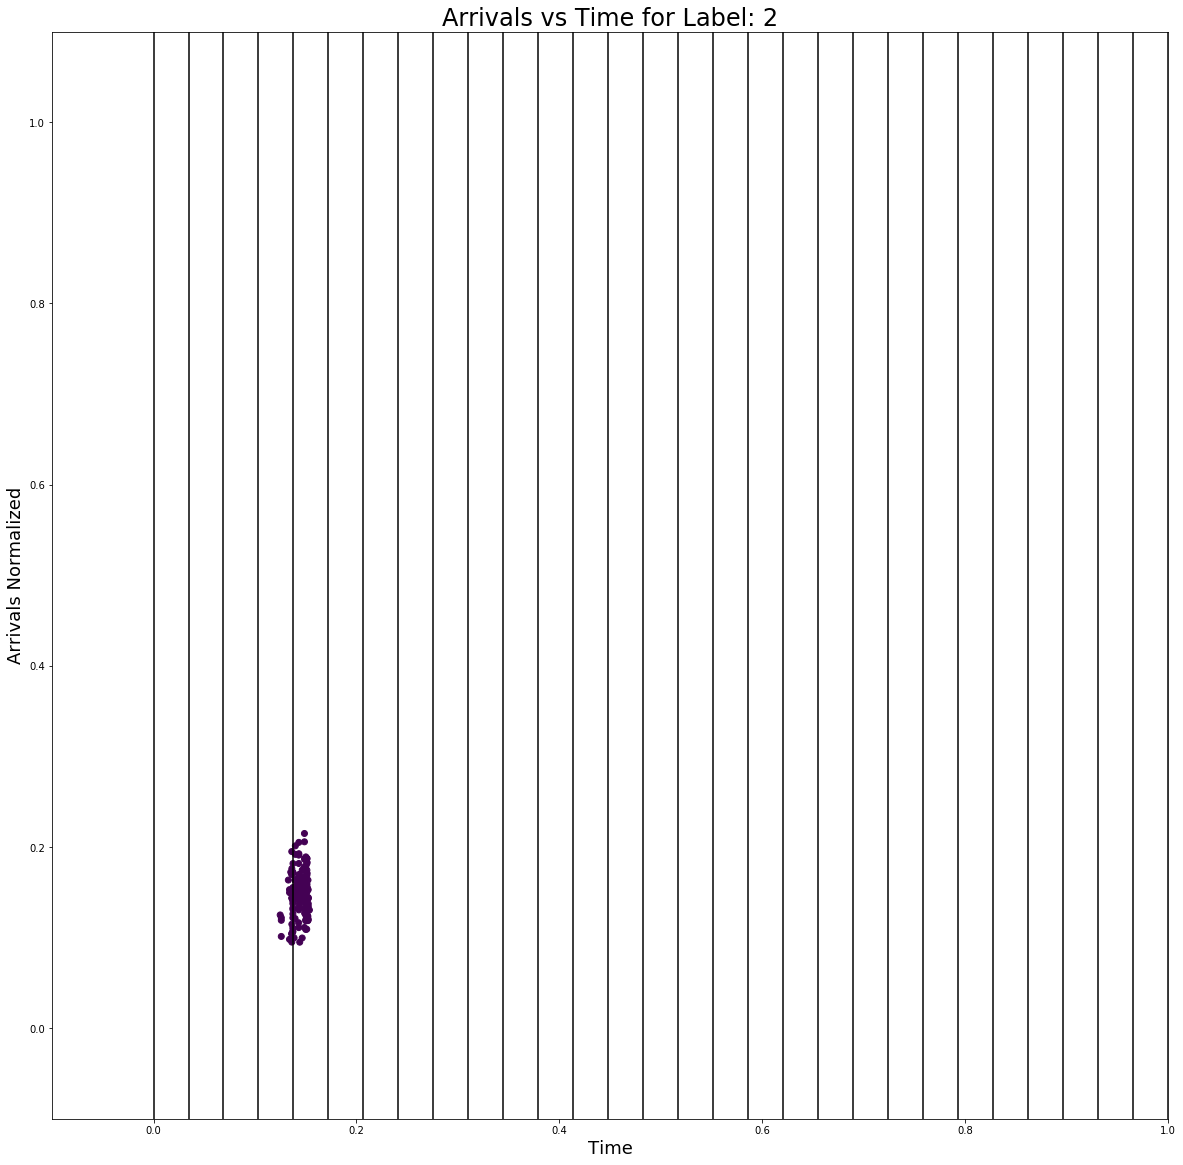

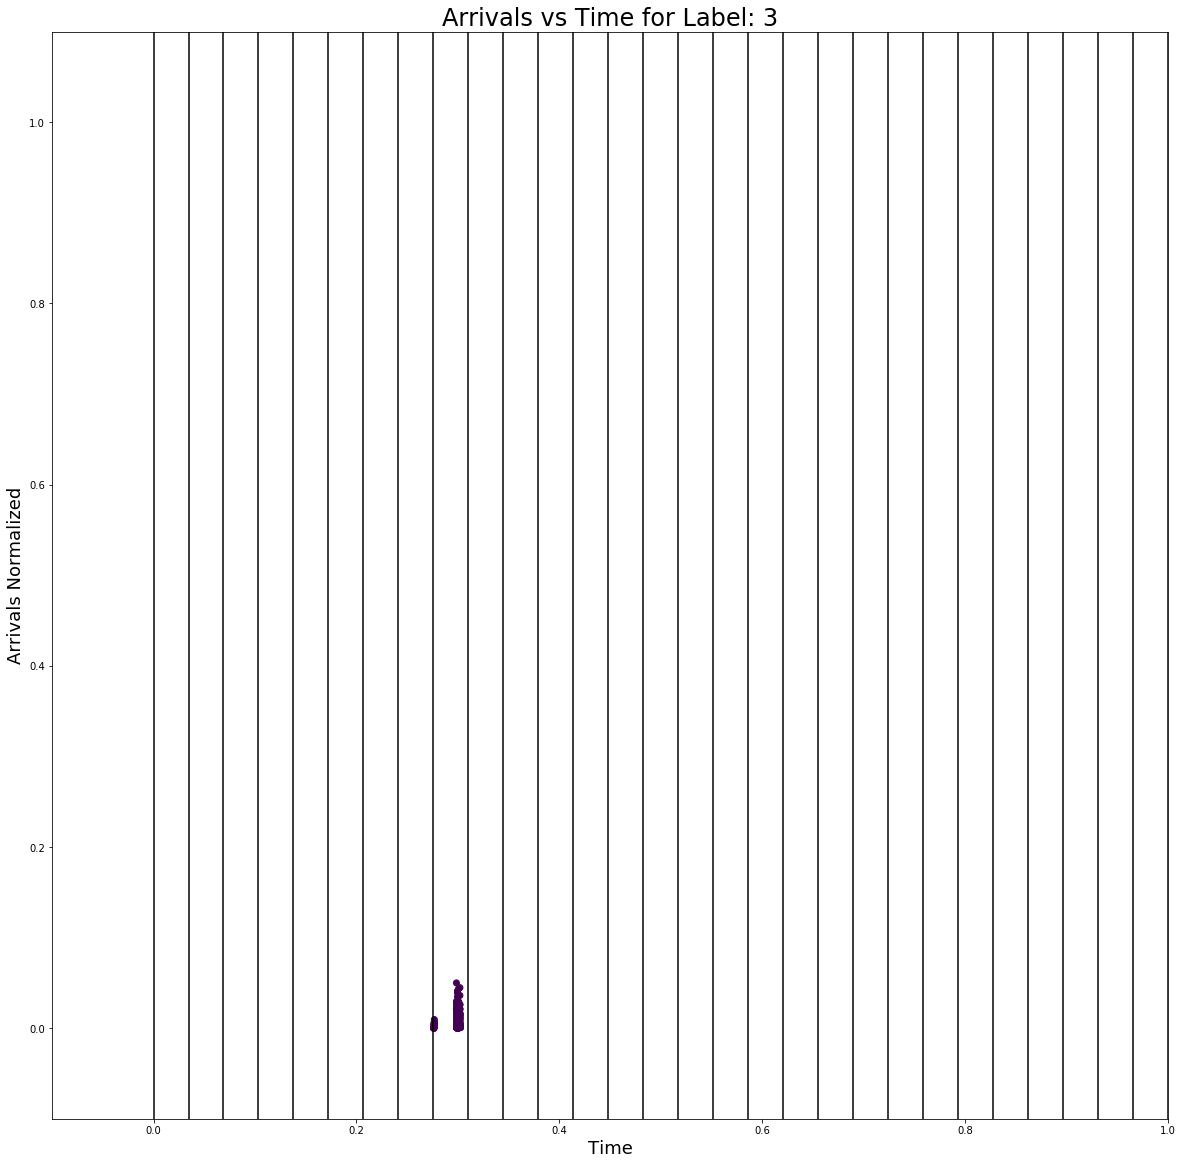

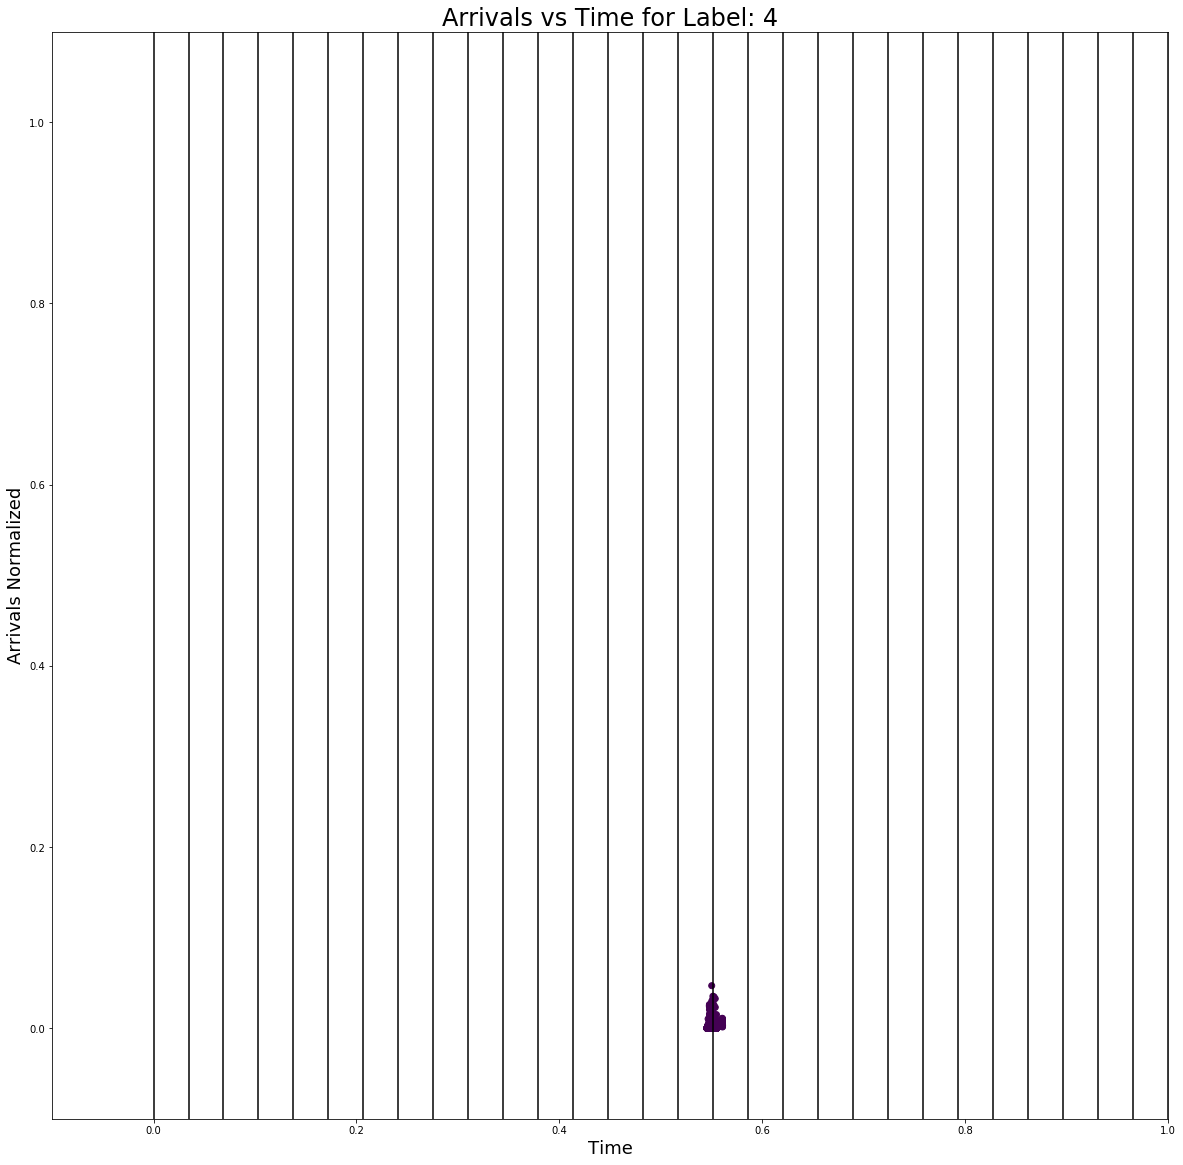

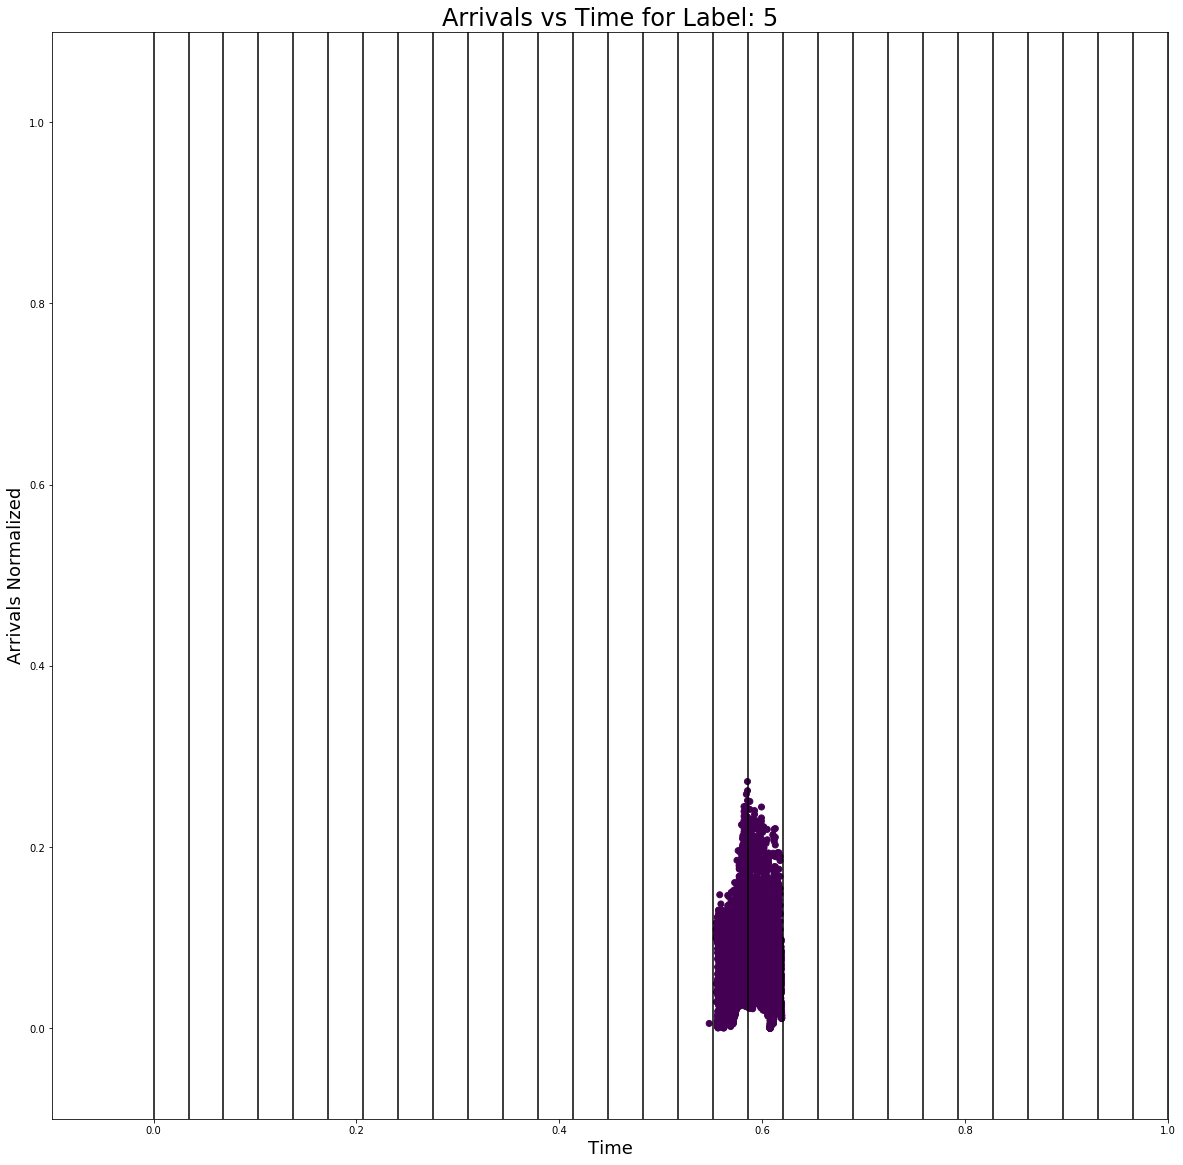

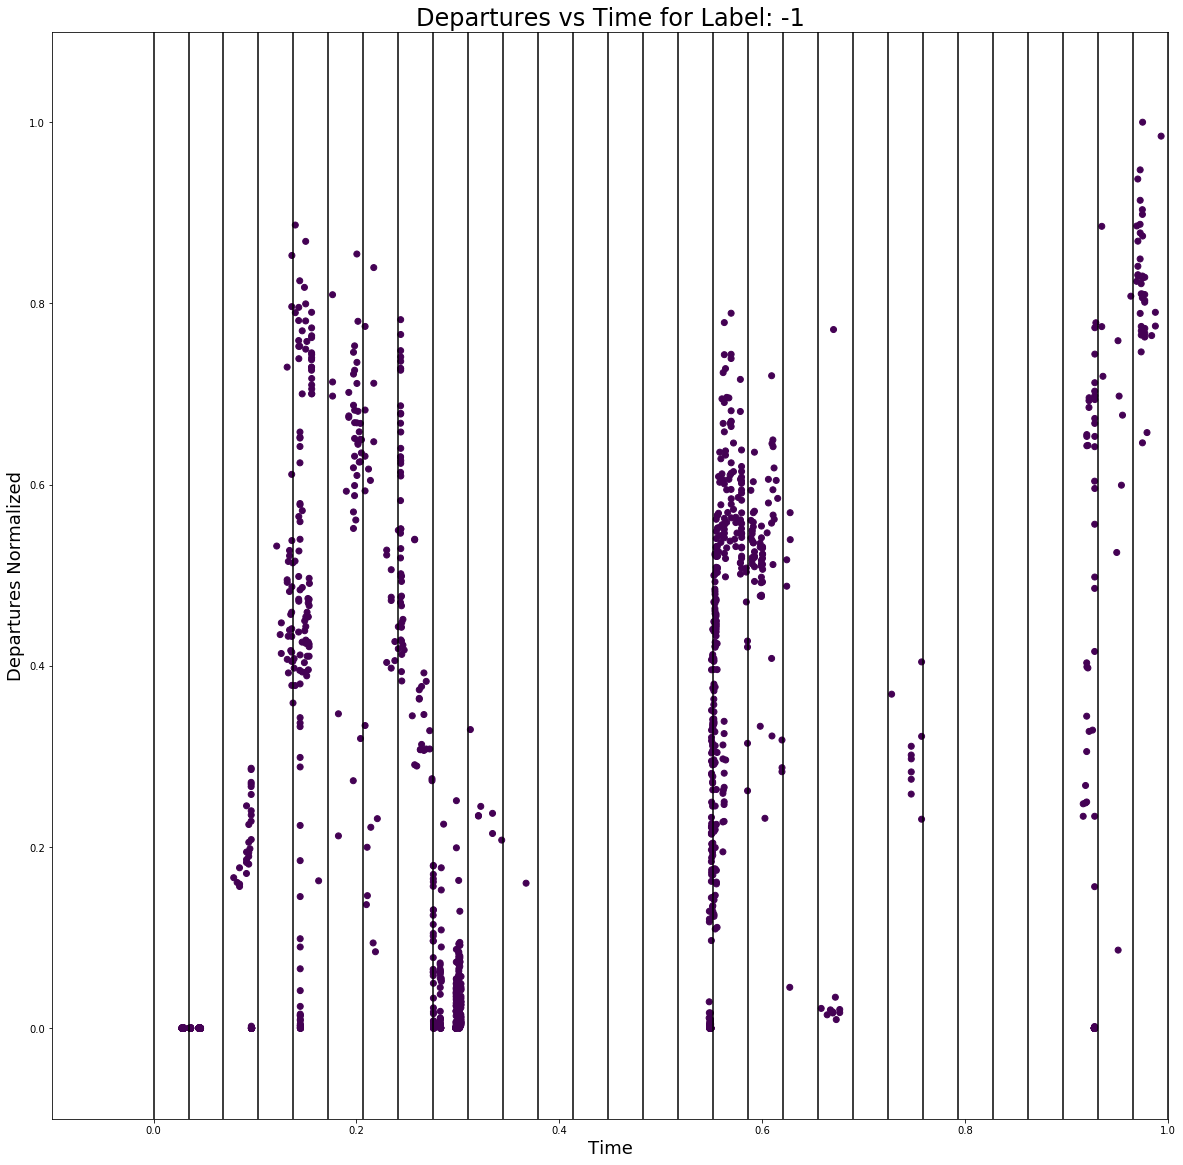

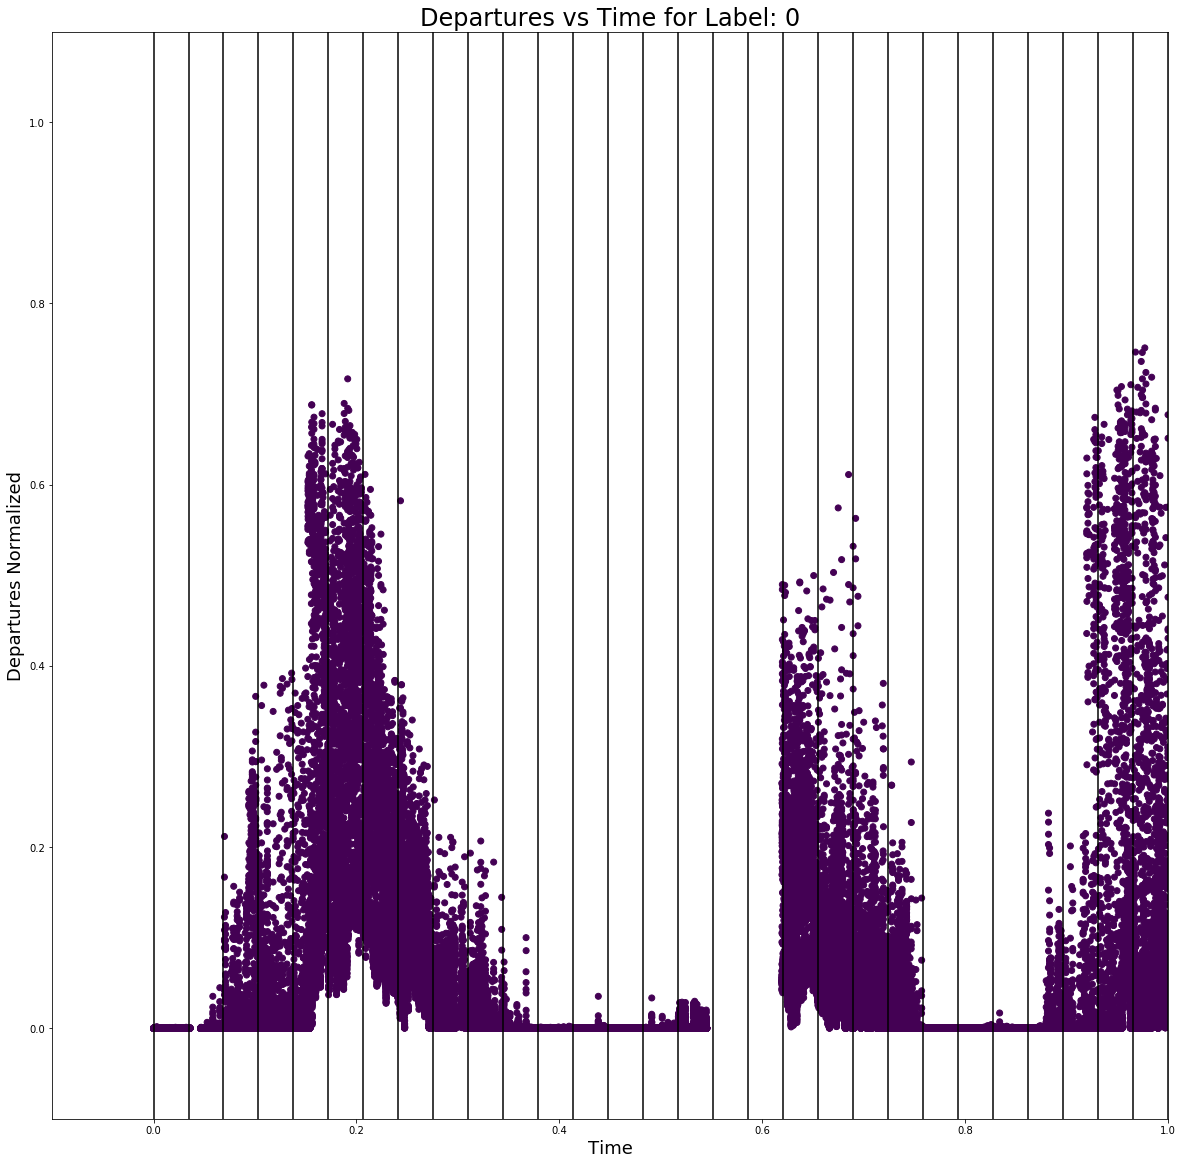

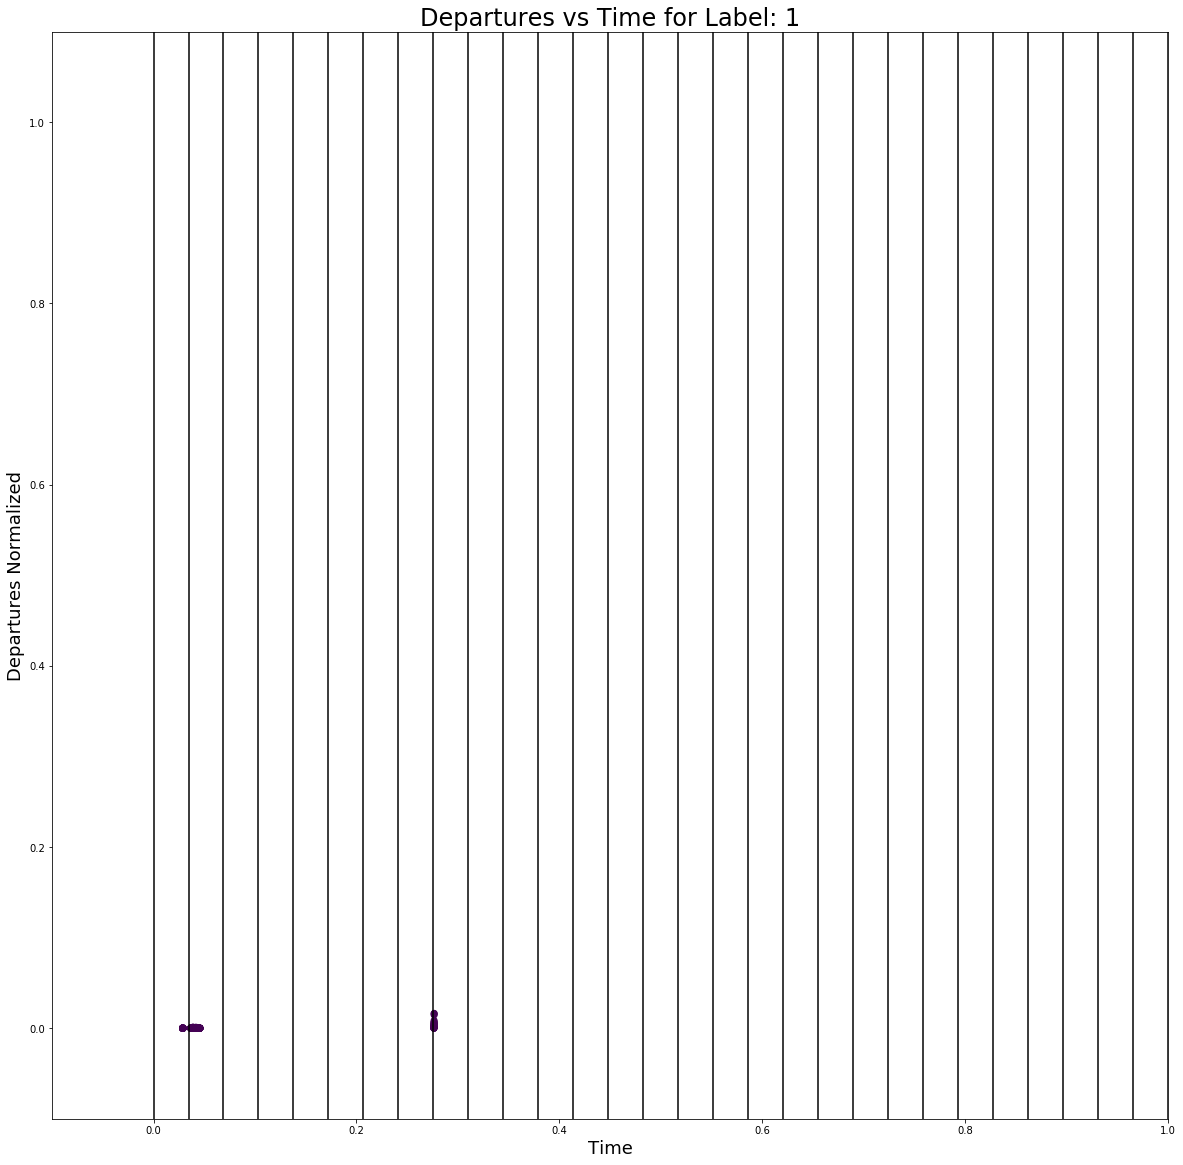

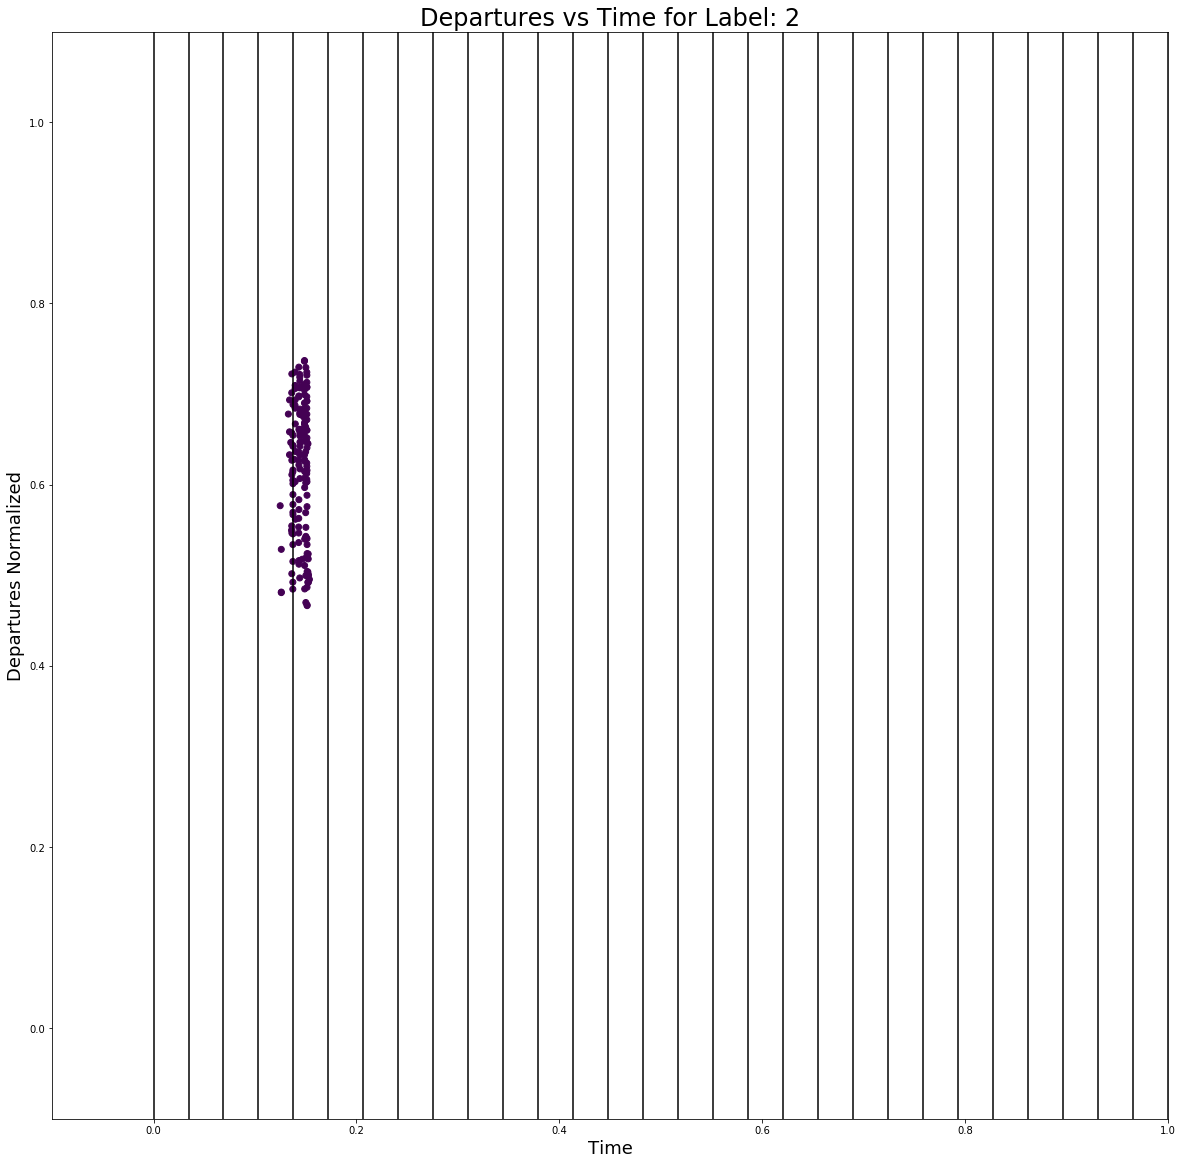

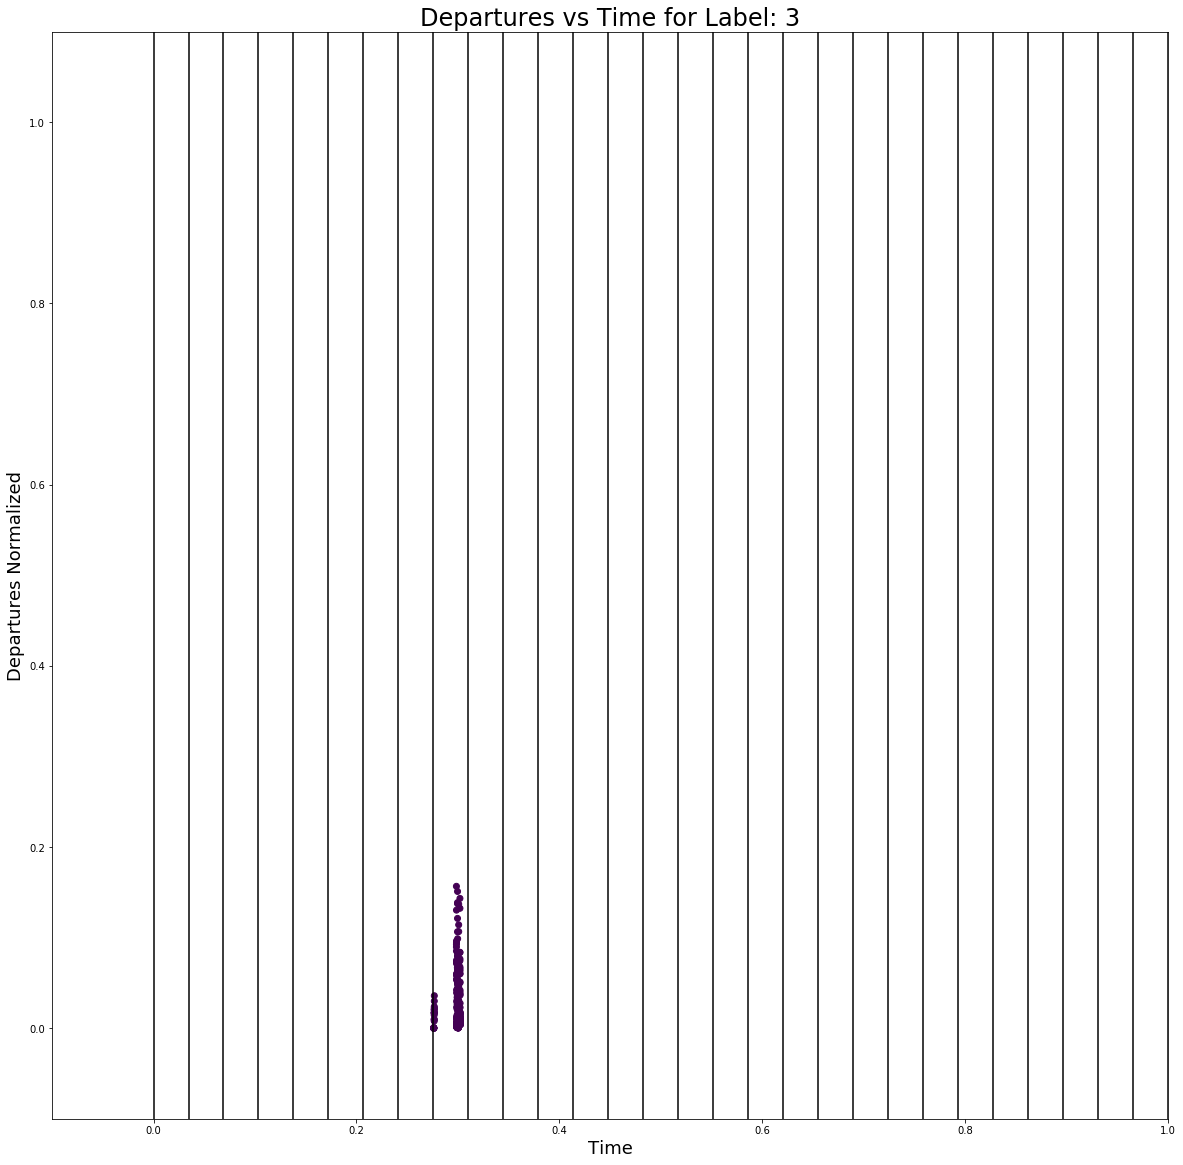

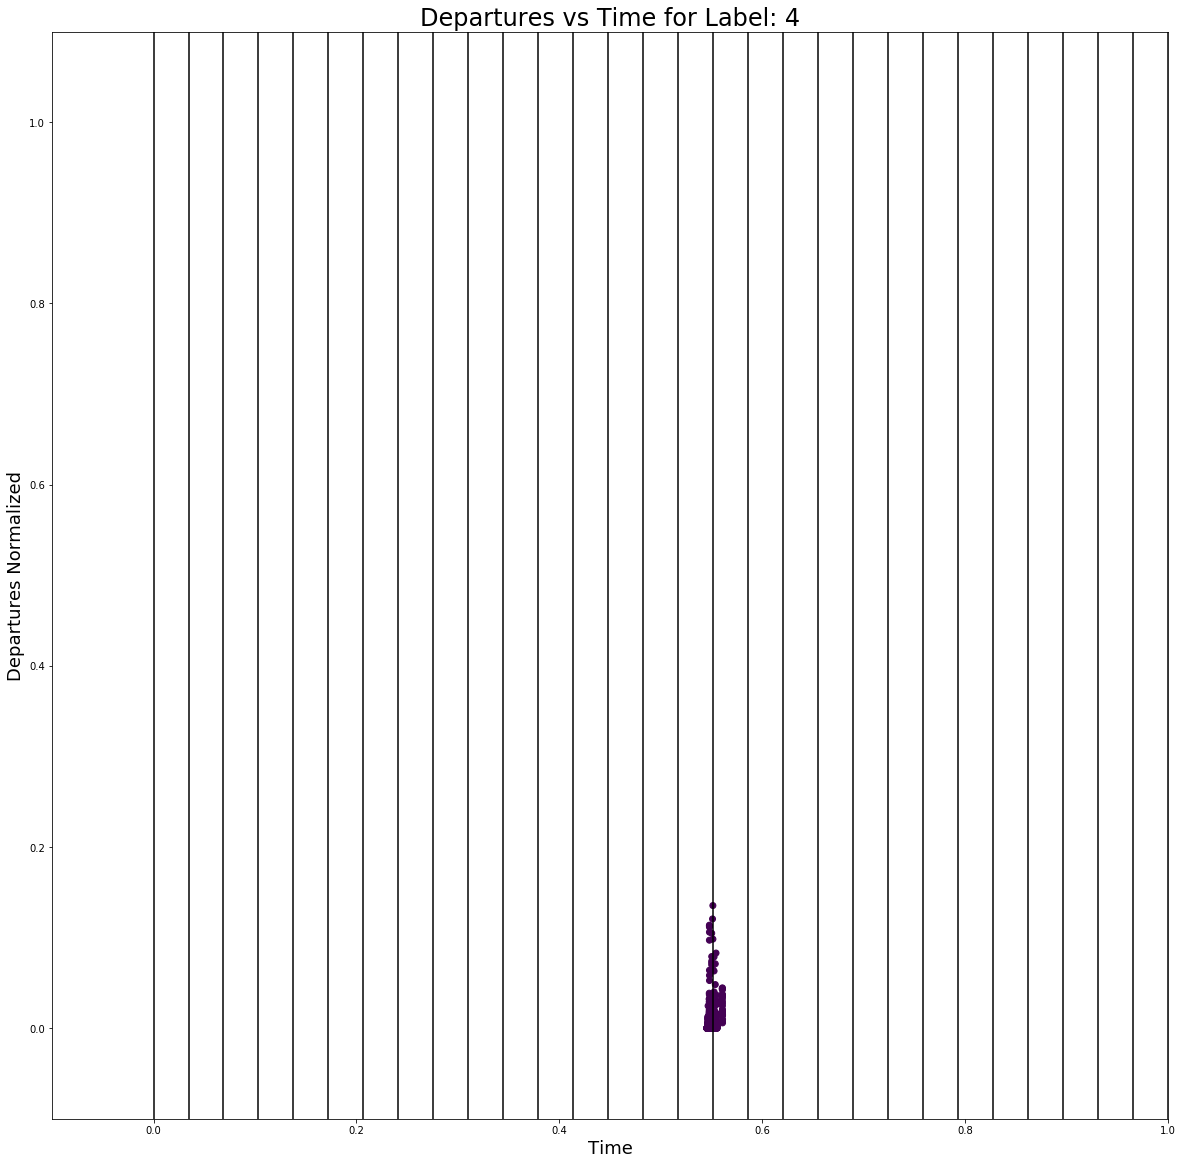

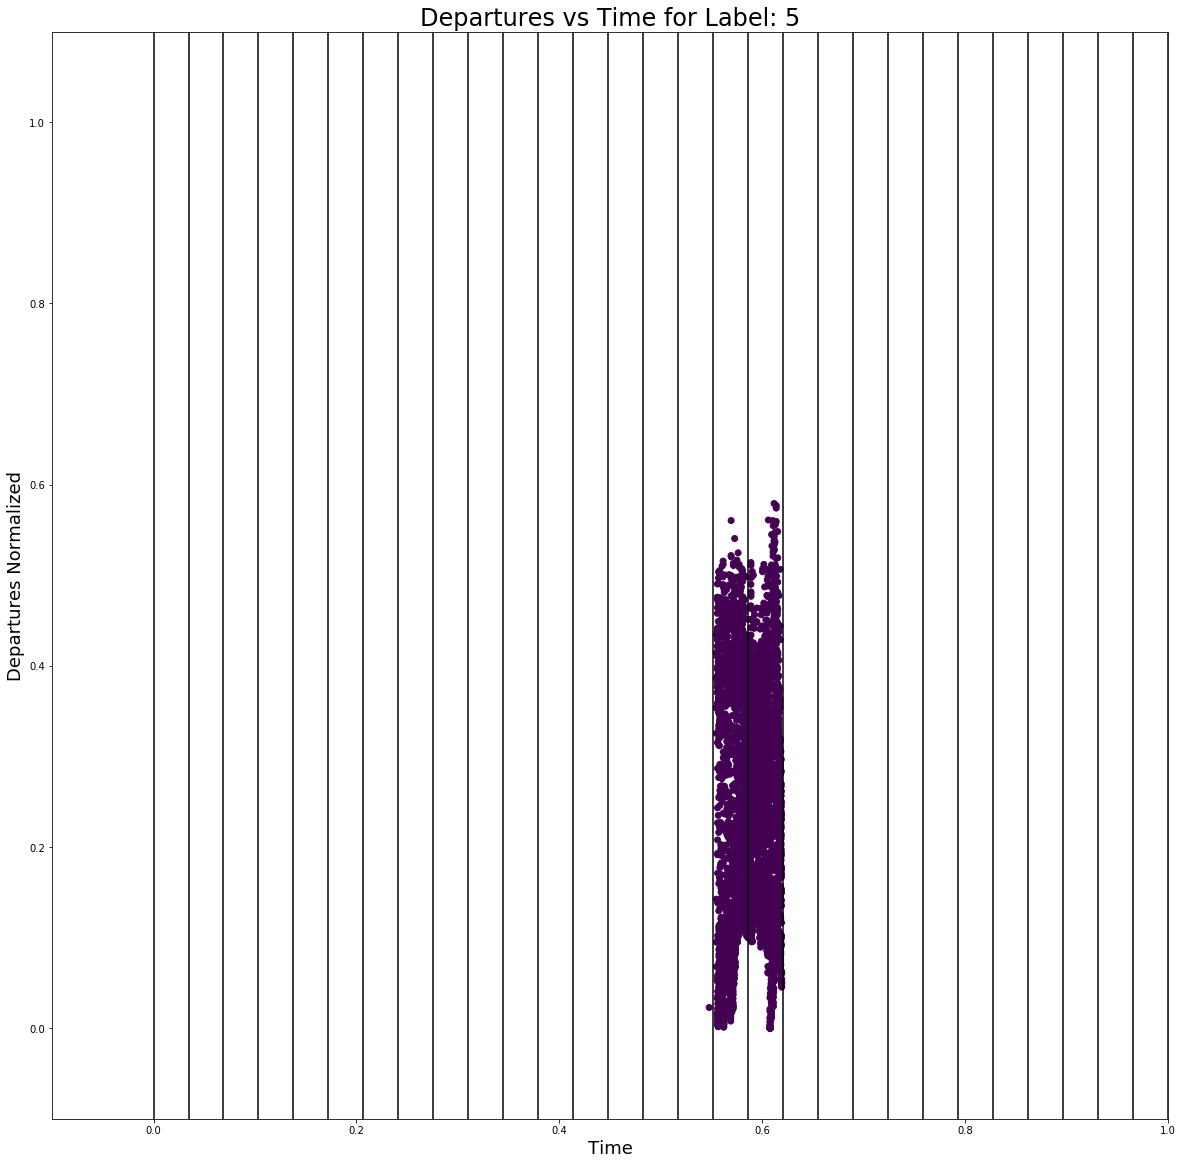

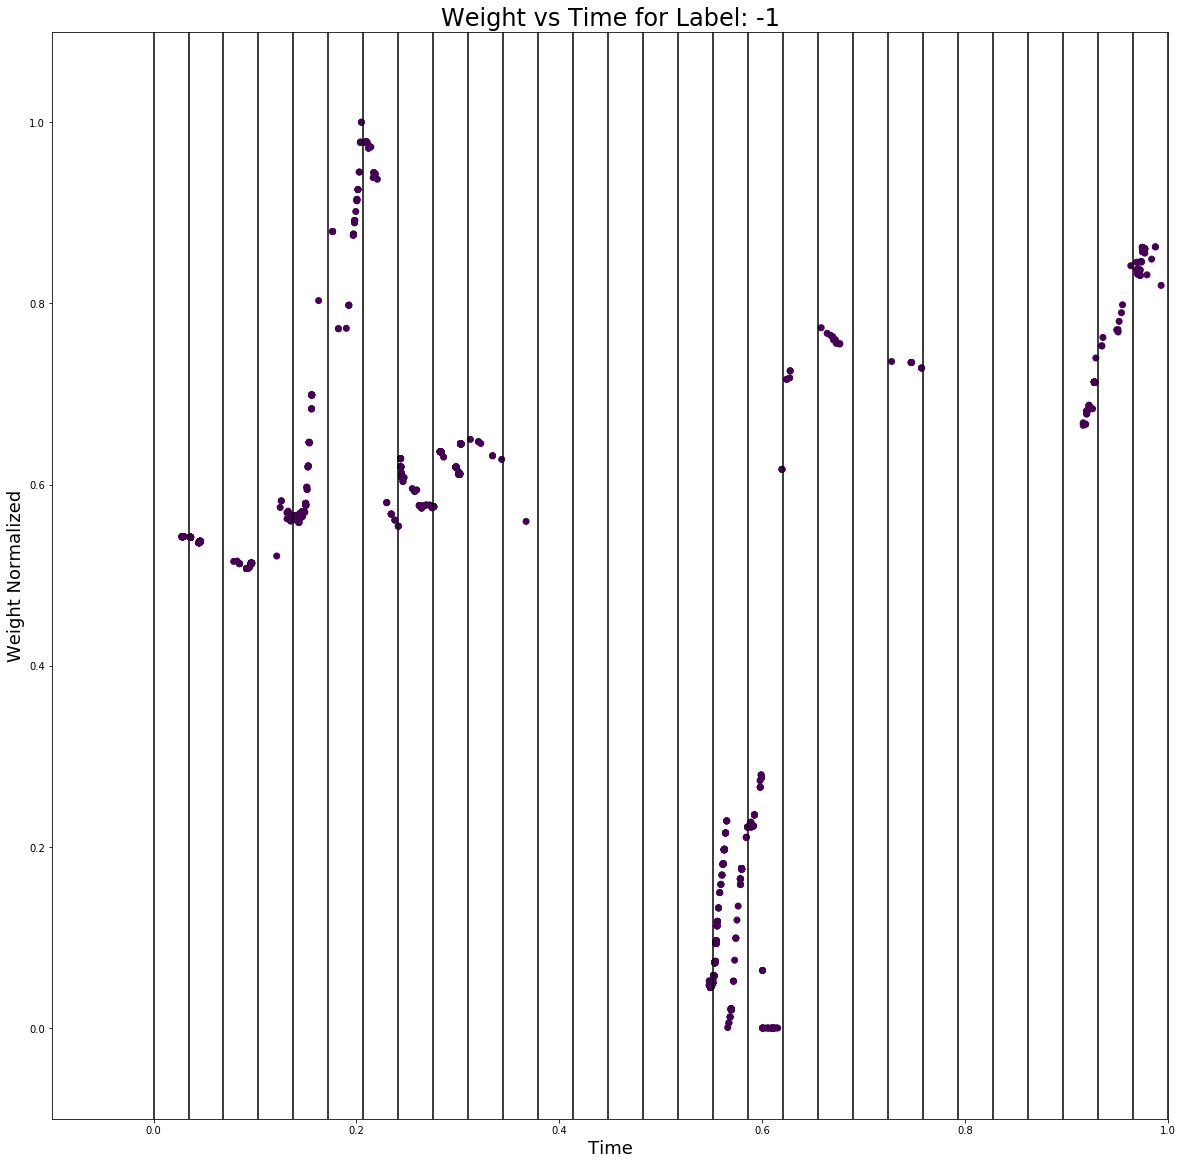

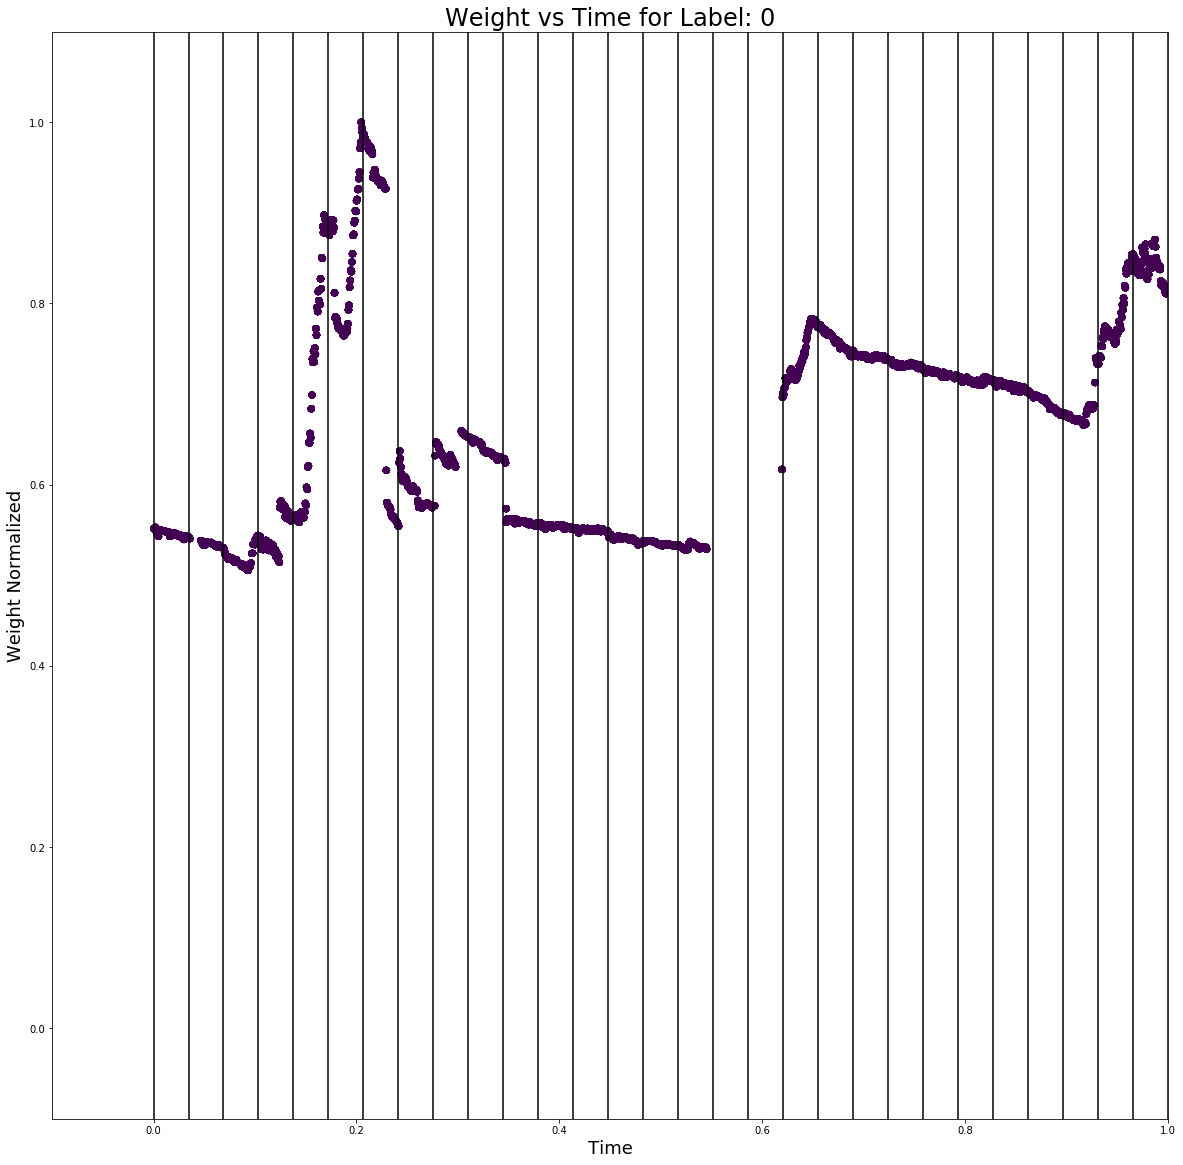

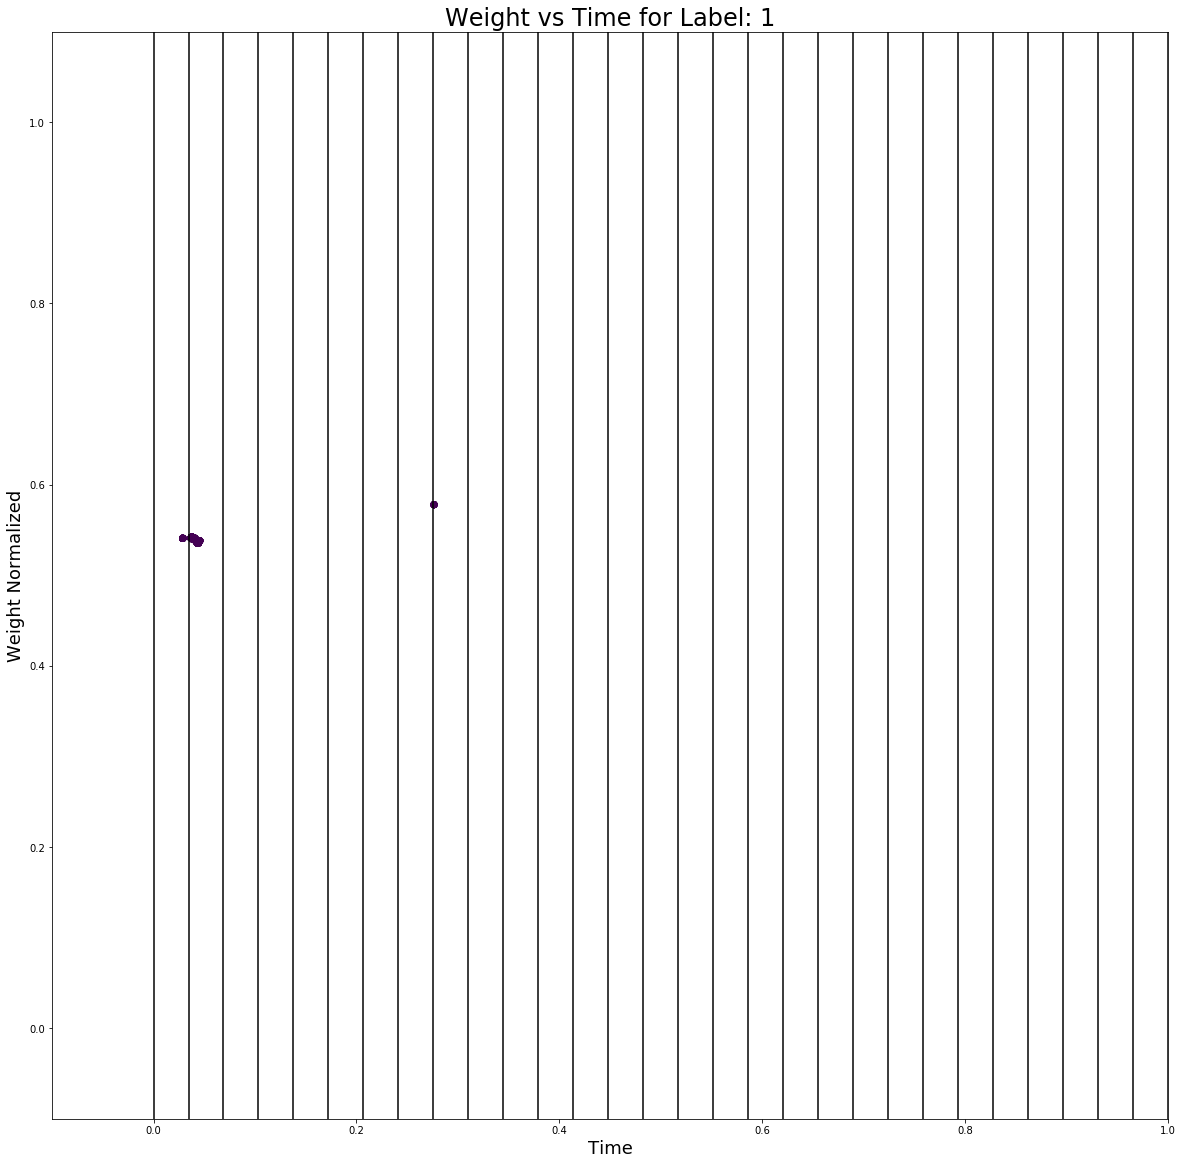

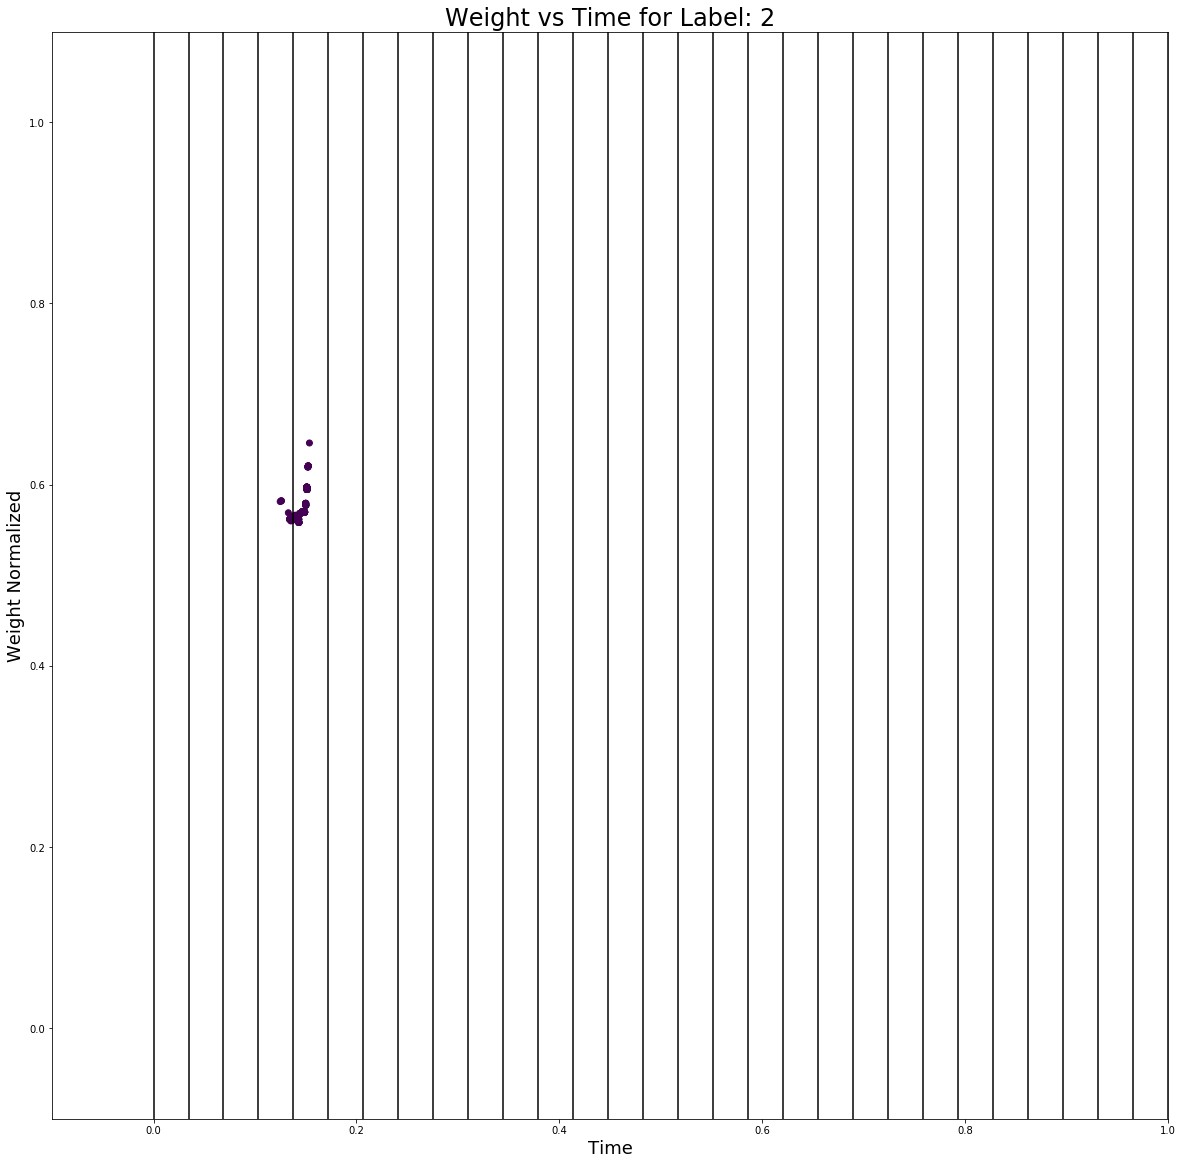

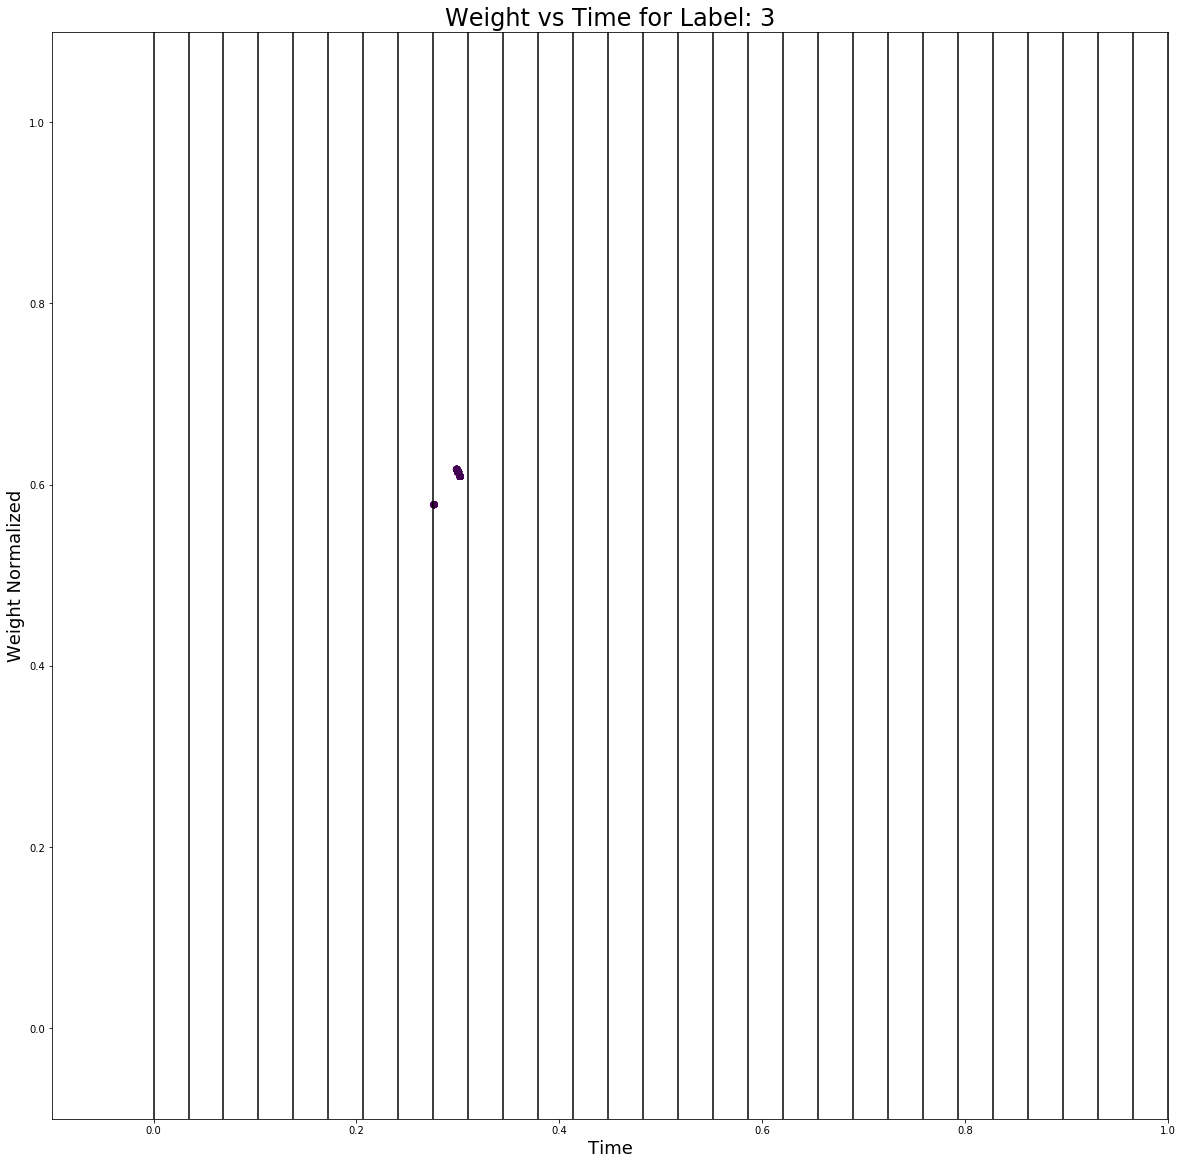

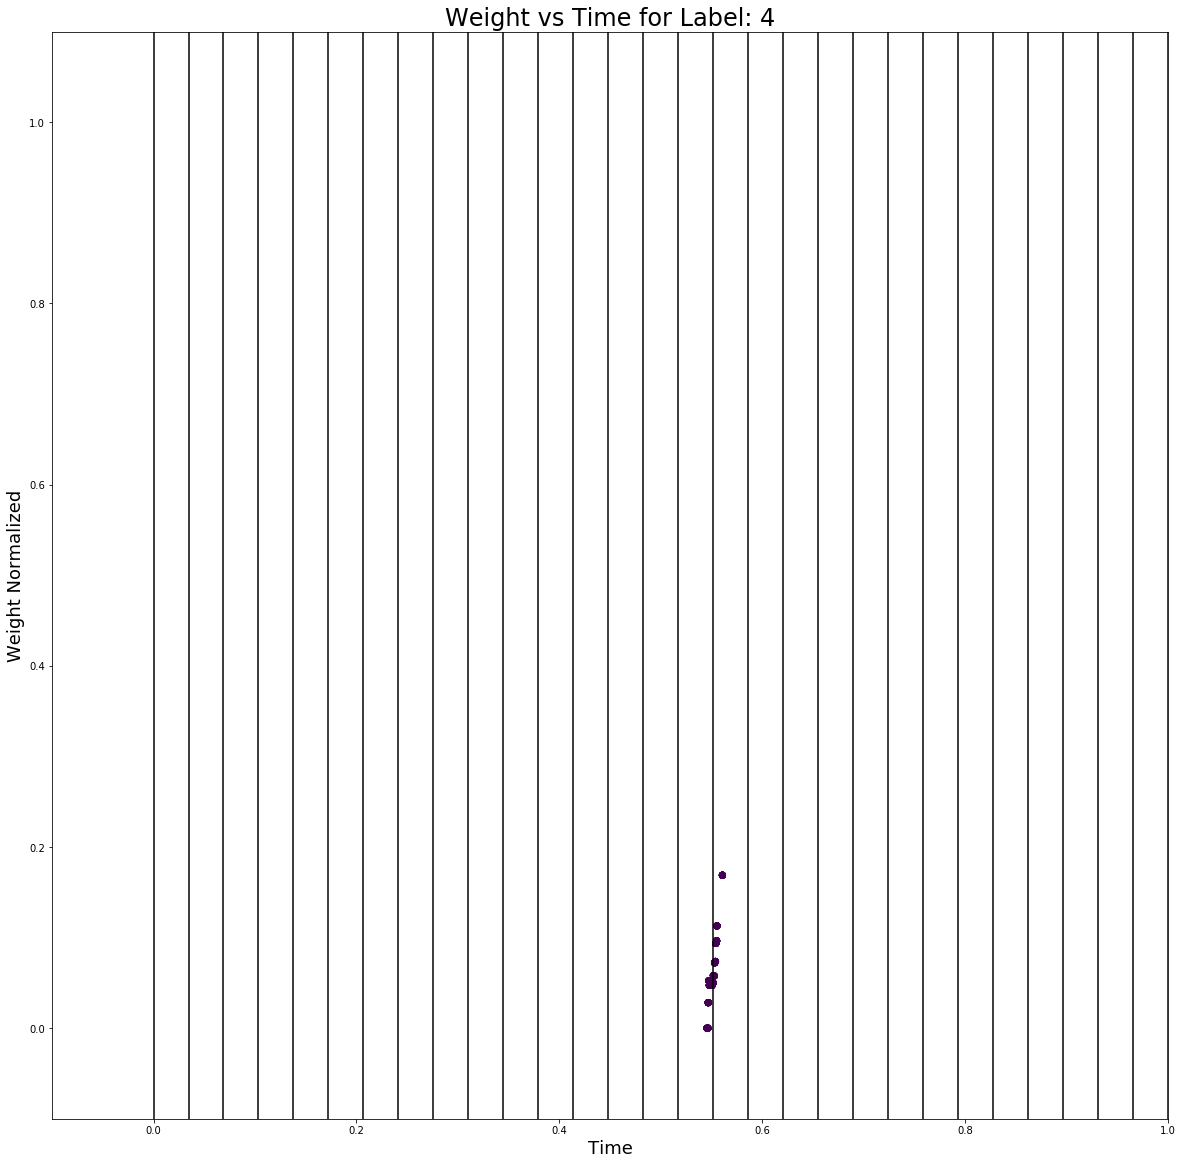

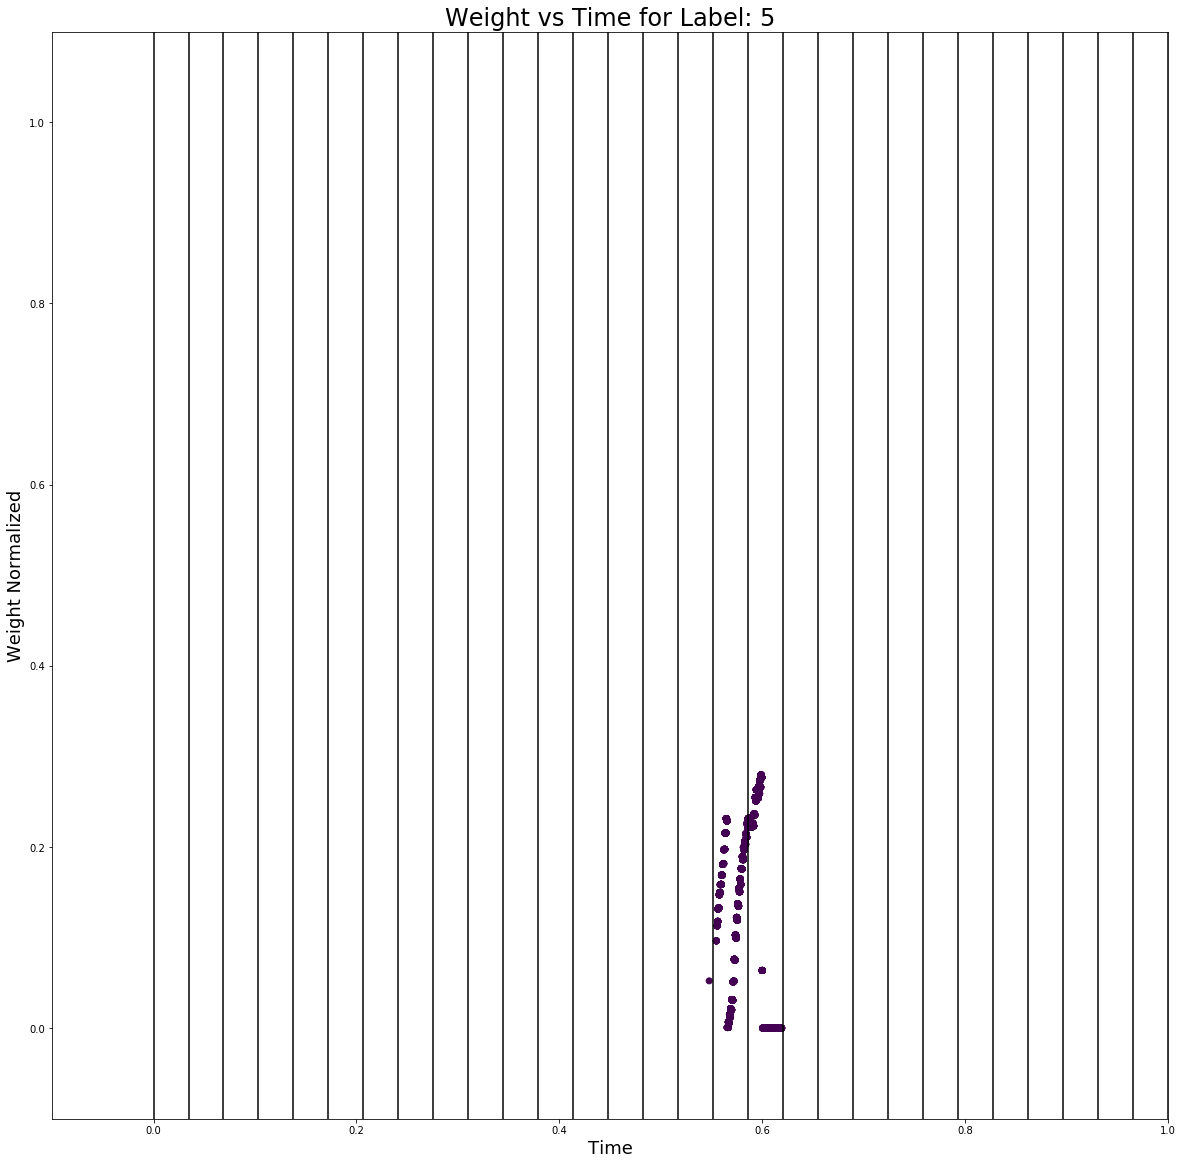

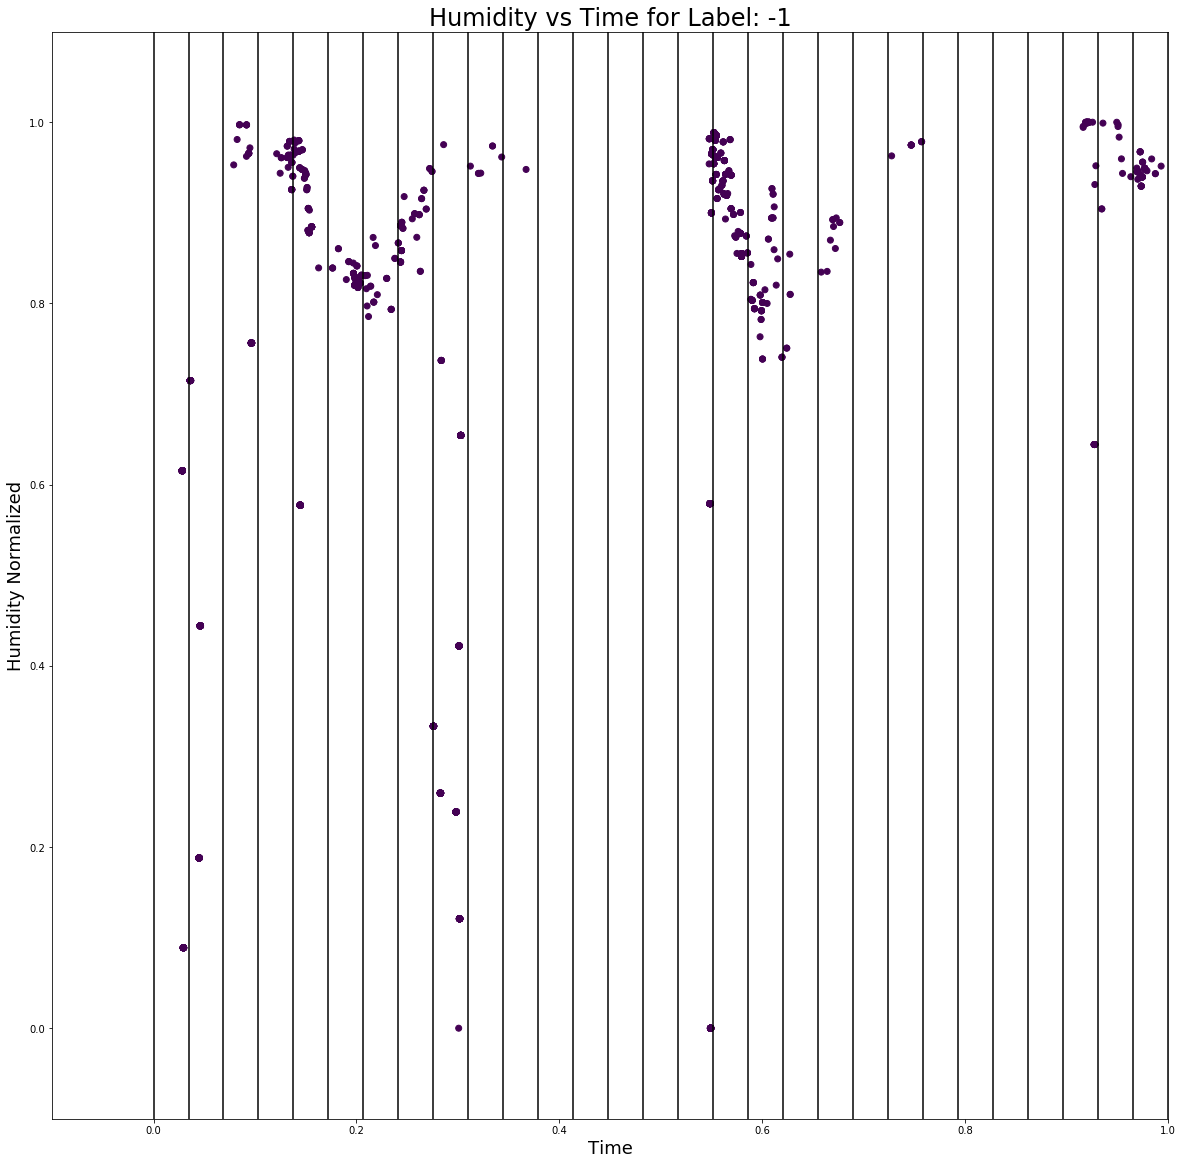

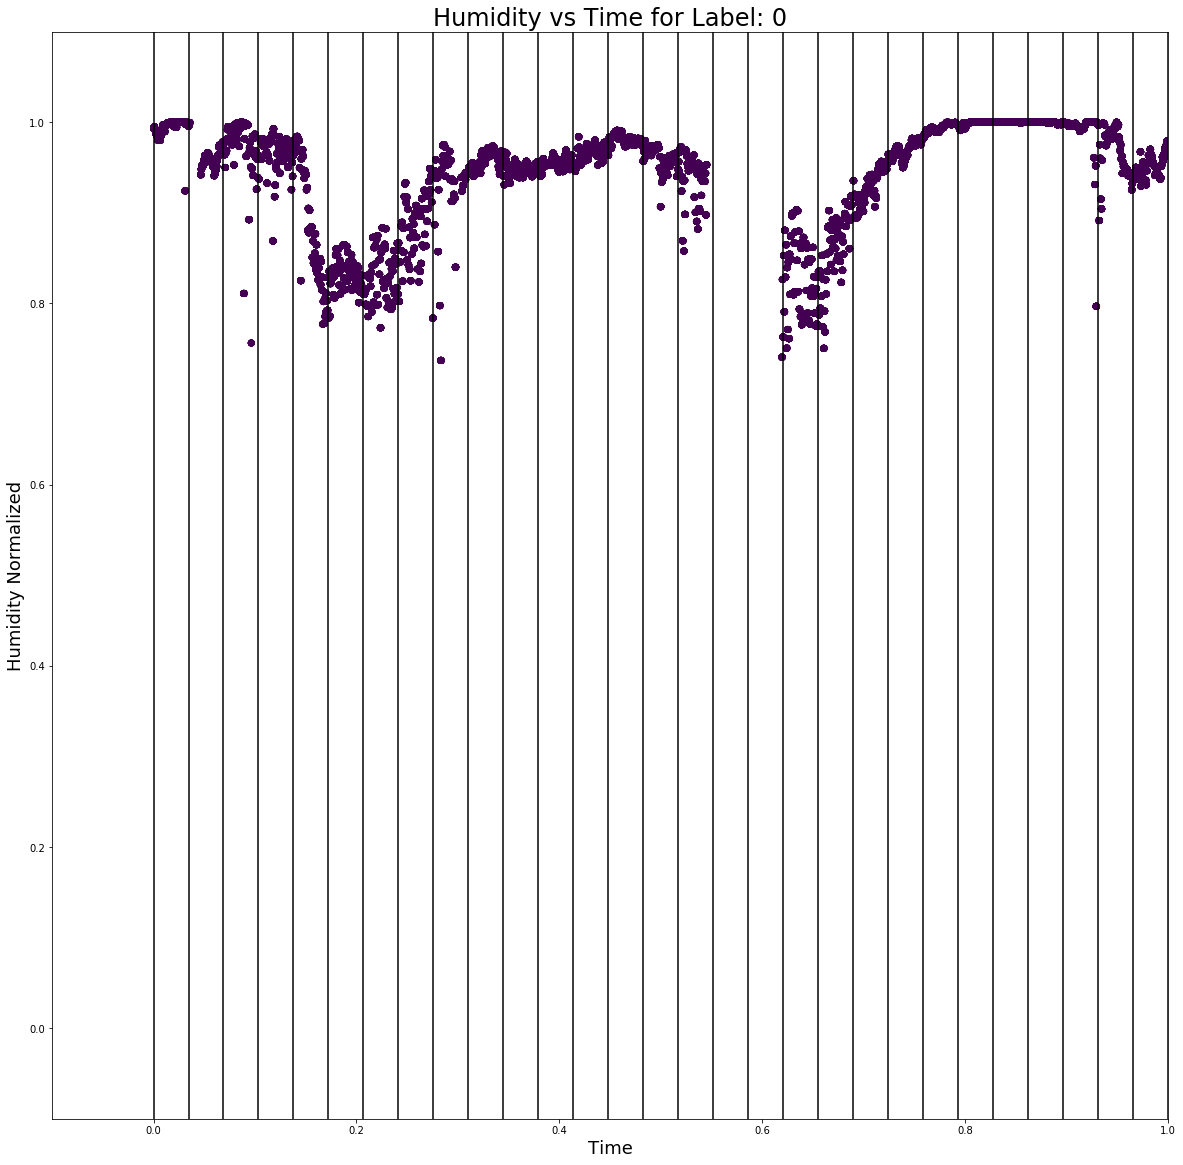

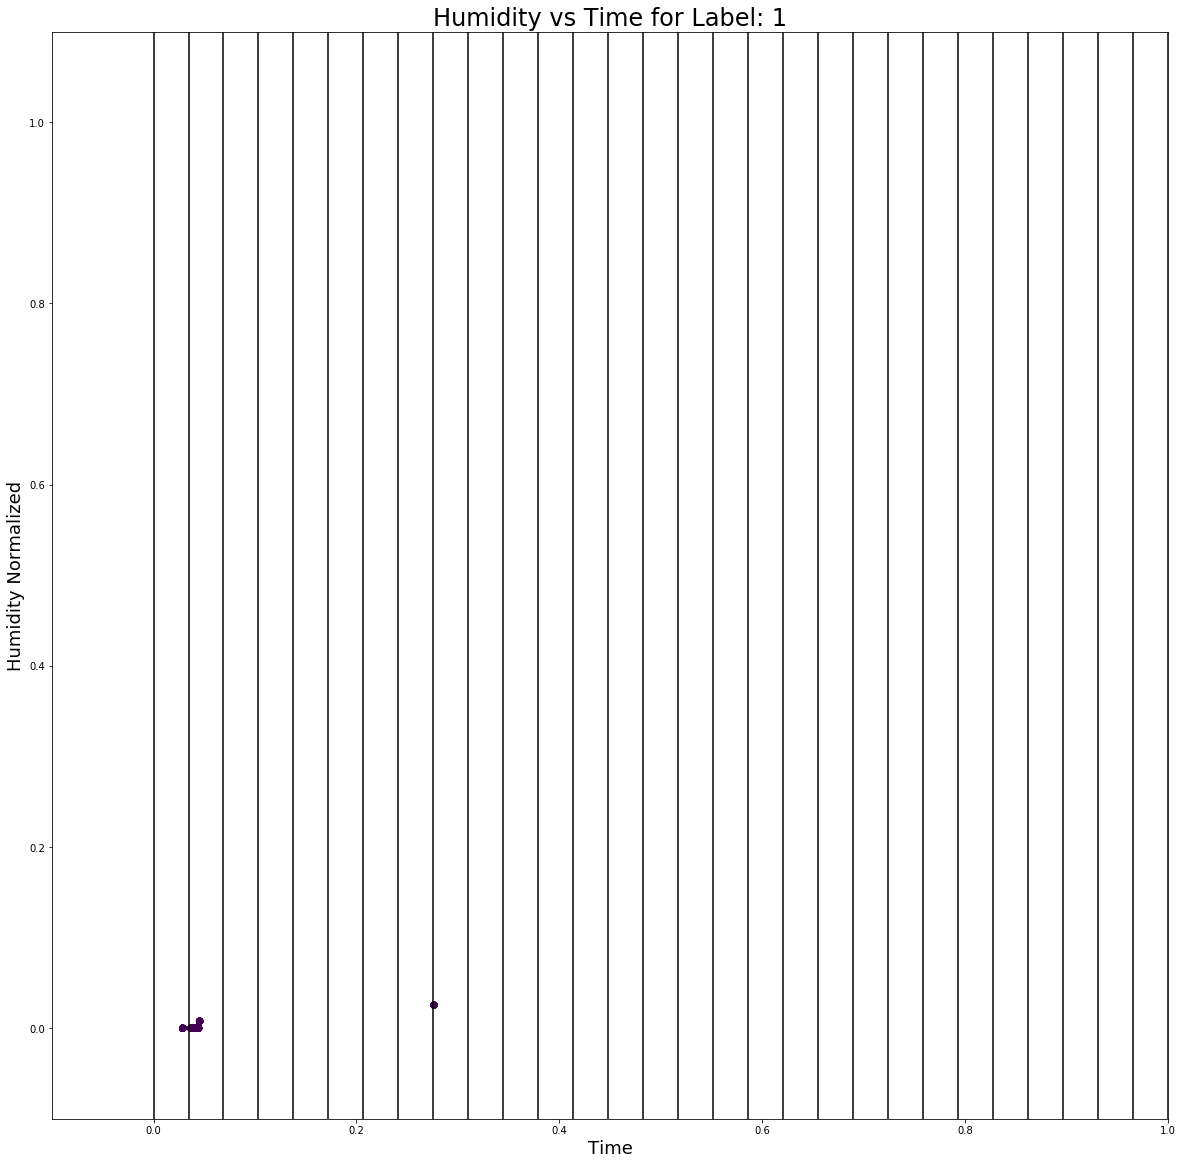

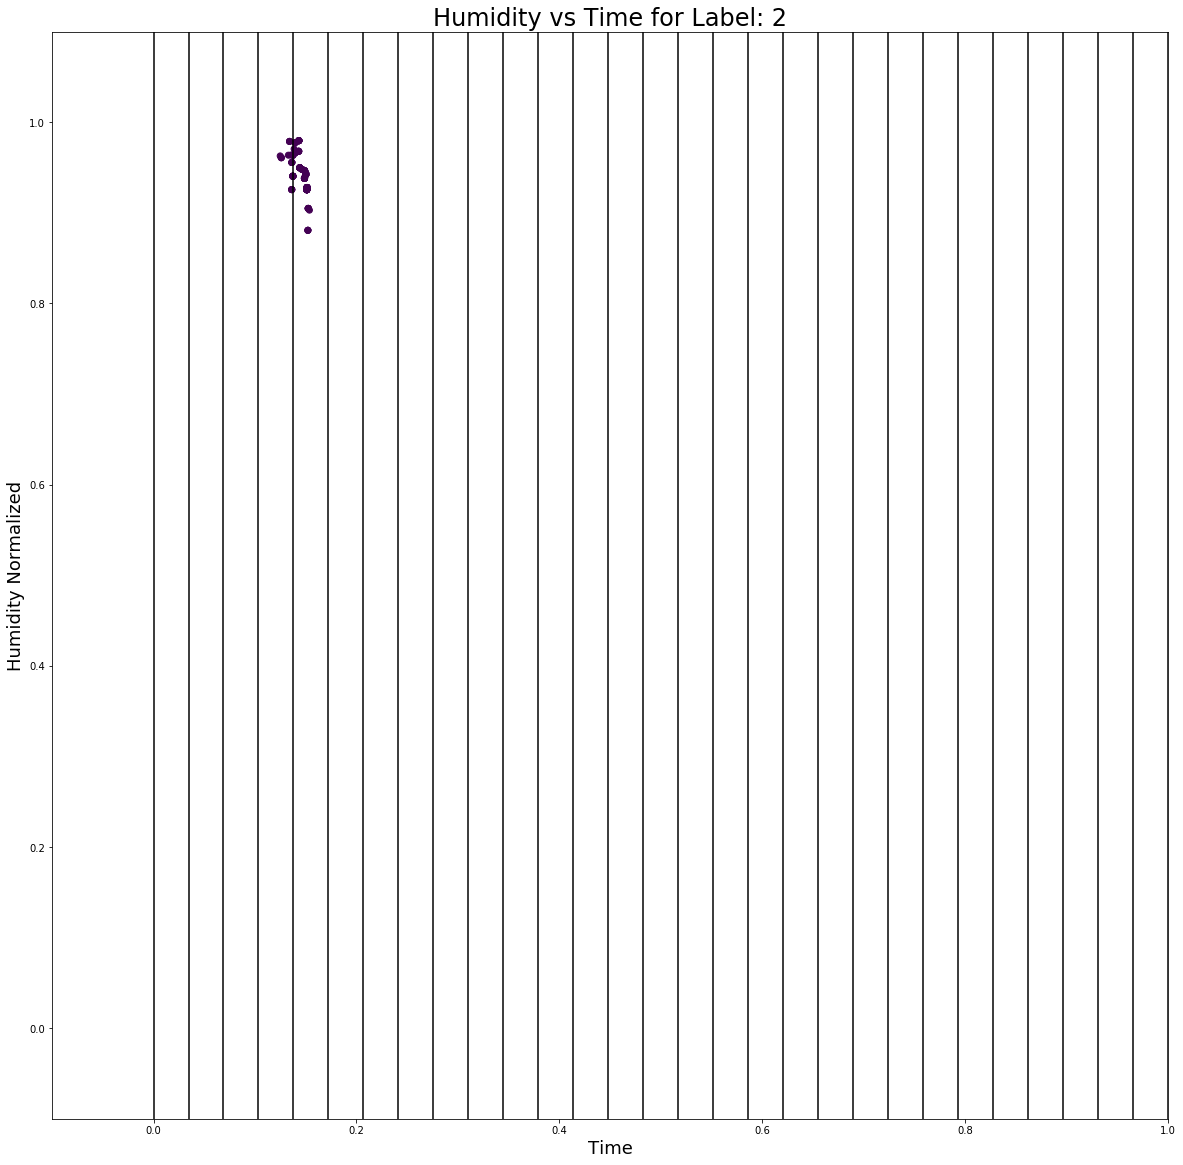

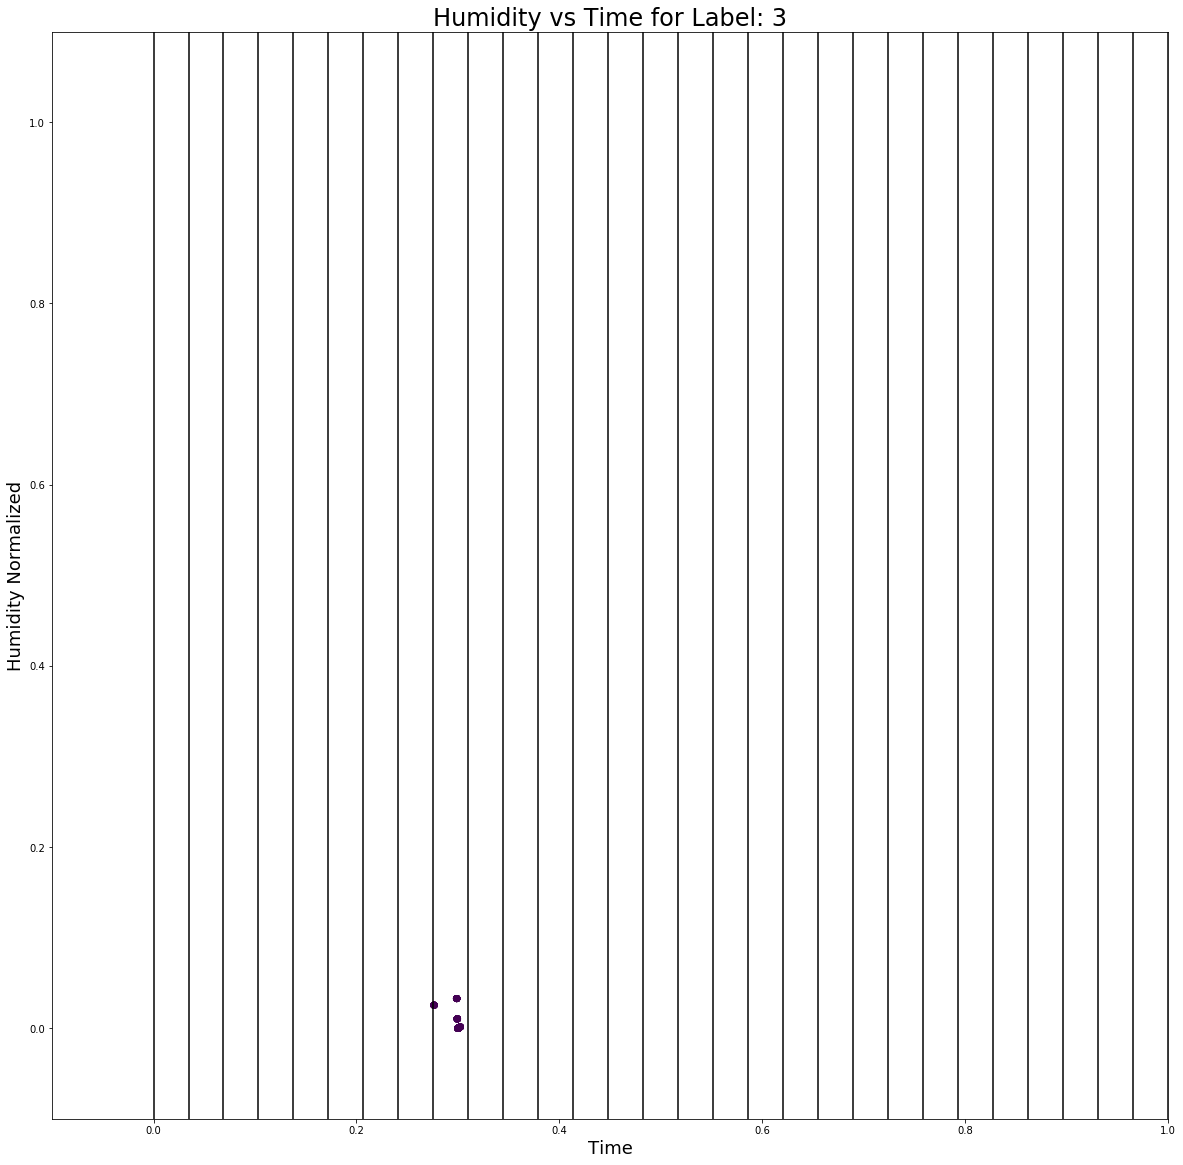

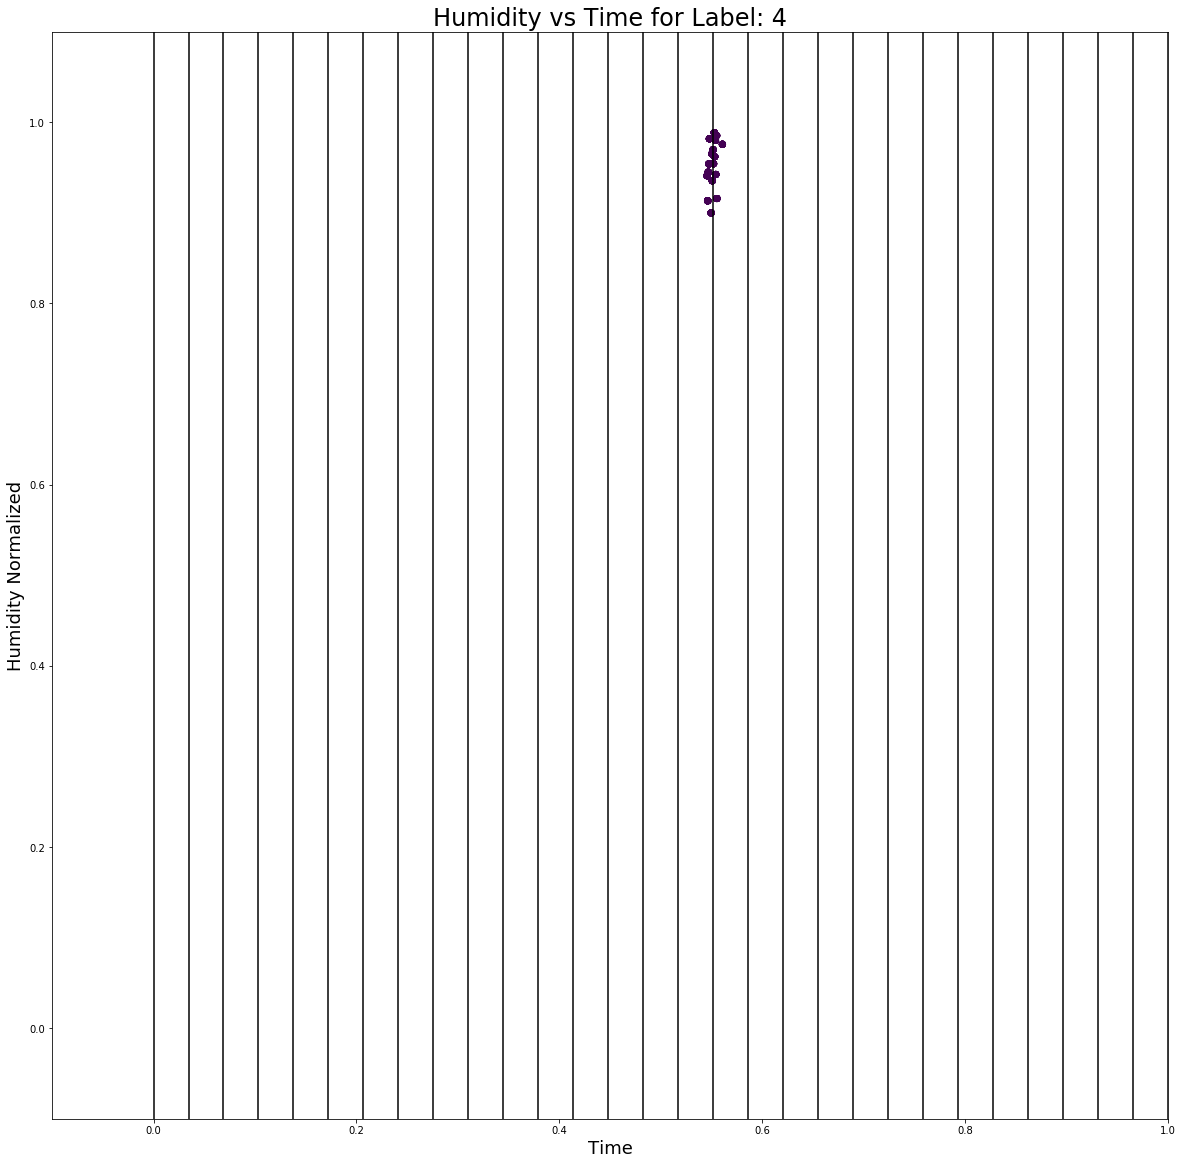

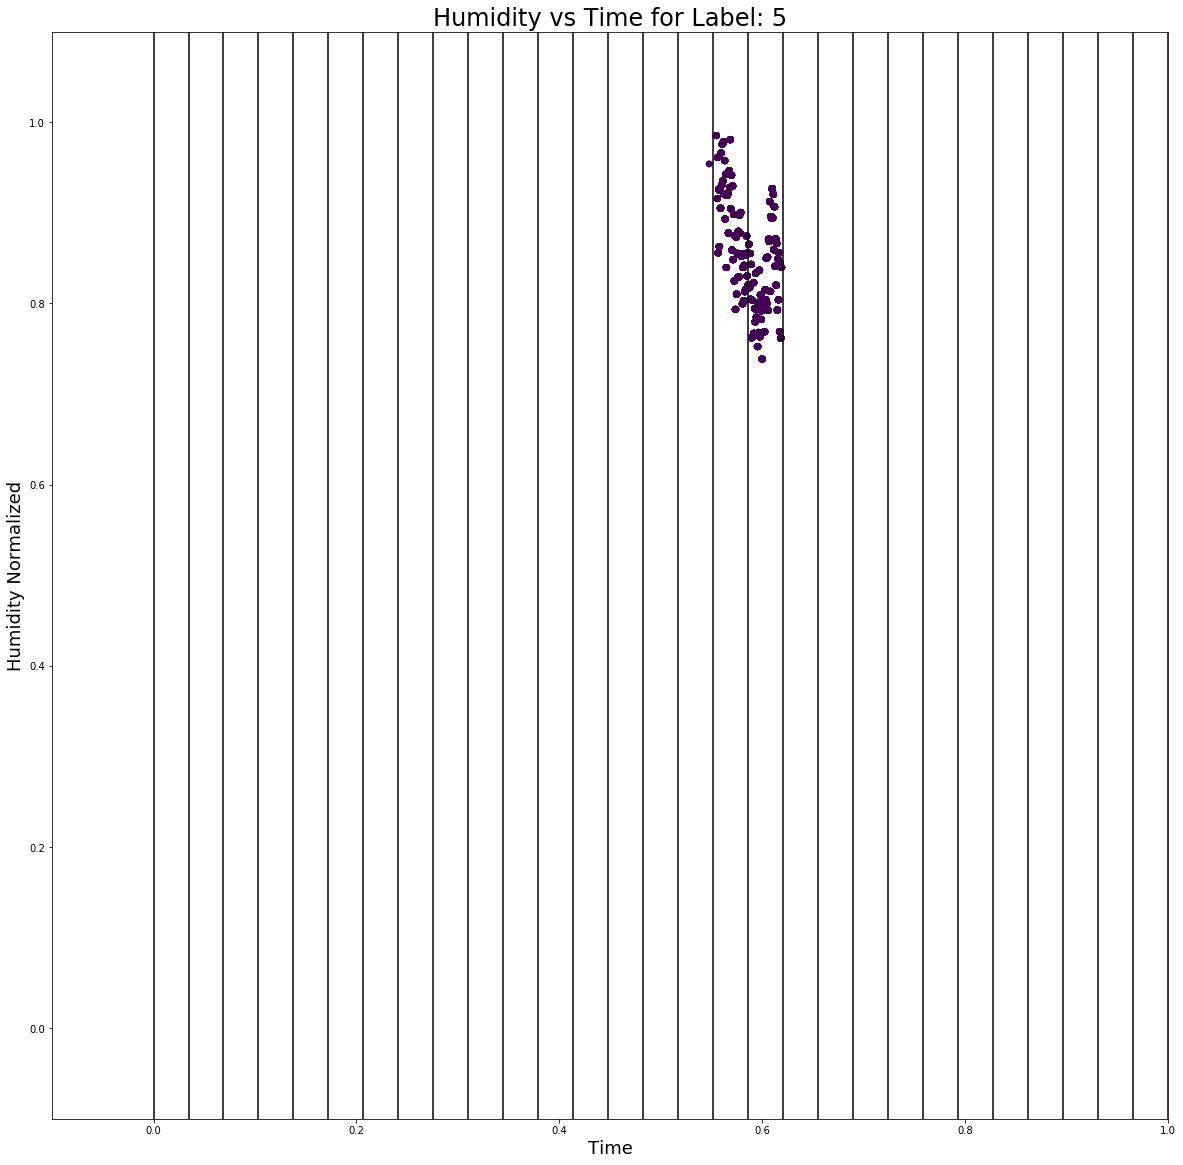

In [32]:
#Graph each attribute per label
for attribute, column in [['Flow', 5], ['Temperature', 4], ['Arrivals', 3], ['Departures', 2], ['Weight', 1], ['Humidity', 0]]:
    for label in range(-1, clusters):
        plt.figure(figsize=(20,20))
        indexes = [index for index, lbl in enumerate(labels) if lbl == label]
        plt.title(f'{attribute} vs Time for Label: {label}', fontsize=24)
        plt.ylabel(f'{attribute} Normalized', fontsize=18)
        plt.xlabel('Time', fontsize=18)
        for i in range(30):
            plt.axvline(x=i/29, c='black')
        plt.xlim(right=1)
        plt.xlim(left=-0.1)
        plt.ylim(top=1.1)
        plt.ylim(bottom=-0.1)
        plt.scatter(timestamps[indexes], X[:,column][indexes], c=labels[indexes])